# Computational Machine Learning COSC2673
## Assignment 2: Machine Learning Project
### Project: Classify Images of Cancer
- Jihun Lee s3753624
- Denster Joseph Frank s3894695

# Data Load

In [1]:
#Importing Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mli
import seaborn as sns
import zipfile
import tensorflow as tf
import math
import keras_tuner
import warnings
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dropout, MaxPooling2D, BatchNormalization, Flatten, Dense
from sklearn.metrics import classification_report, confusion_matrix
warnings.filterwarnings("ignore")

In [2]:
with zipfile.ZipFile('Image_classification_data.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [3]:
# To read each individual dataframe
cancer_data=pd.read_csv("data_labels_mainData.csv", delimiter=',')

In [4]:
# To see first 5 items of the dataframe
cancer_data.head(5)

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

In [5]:
# Working on copy of data,  original data will be safe
df_cancer_data=cancer_data.copy()

In [6]:
# To find shape of dataframe
df_cancer_data.shape

(9896, 6)

This code loads data from a CSV file containing information about images of cells and their corresponding labels. The dataset has six columns: InstanceID, patientID, ImageName, cellTypeName, cellType, and isCancerous. After importing necessary libraries, the code uses Pandas to load the data and display the first five rows of the DataFrame. A copy of the DataFrame is then created to ensure that the original data is not modified during processing. Finally, the shape of the DataFrame is printed to confirm that the data has been loaded successfully. This code is an important first step in preparing the data for image classification.

# Data Cleaning

### Checks for null values

In [7]:
#To check is there any null value
df_cancer_data.isnull().values.any()

False

In [8]:
#To check percentage of null values in each column
df_cancer_data.isnull().sum()*100/len(df_cancer_data)

InstanceID      0.0
patientID       0.0
ImageName       0.0
cellTypeName    0.0
cellType        0.0
isCancerous     0.0
dtype: float64

In [9]:
# Checking for duplicate rows
df_cancer_data.duplicated().any()

False

In [10]:
#To check datatypes of given datafram
df_cancer_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9896 entries, 0 to 9895
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   InstanceID    9896 non-null   int64 
 1   patientID     9896 non-null   int64 
 2   ImageName     9896 non-null   object
 3   cellTypeName  9896 non-null   object
 4   cellType      9896 non-null   int64 
 5   isCancerous   9896 non-null   int64 
dtypes: int64(4), object(2)
memory usage: 464.0+ KB


In this section, we have found that there are no null values or duplicate rows in the dataset, and all columns except ImageName and cellTypeName are of integer data type. These findings suggest that the dataset is clean and can be used for further analysis.

### converting images into array

In [11]:
img_array = []
for value in df_cancer_data['ImageName']:
    array_value = mli.imread('patch_images/'+value)
    img_array.append(np.mean(array_value.ravel()))

df_cancer_data['ImgArray'] = img_array

df_cancer_data.head(10)

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous  \
0       22405          1  22405.png   fibroblast         0            0   
1       22406          1  22406.png   fibroblast         0            0   
2       22407          1  22407.png   fibroblast         0            0   
3       22408          1  22408.png   fibroblast         0            0   
4       22409          1  22409.png   fibroblast         0            0   
5       22410          1  22410.png   fibroblast         0            0   
6       22411          1  22411.png   fibroblast         0            0   
7       22412          1  22412.png   fibroblast         0            0   
8       22413          1  22413.png   fibroblast         0            0   
9       22414          1  22414.png   fibroblast         0            0   

   ImgArray  
0  0.784387  
1  0.773840  
2  0.746852  
3  0.868517  
4  0.835818  
5  0.731659  
6  0.773984  
7  0.735100  
8  0.775350  
9  0.744072

In [12]:
with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(df_cancer_data, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 5937, Val Data: 1979, Test Data: 1980


The dataset is split into three parts: training set, validation set, and test set using the train_test_split function from sklearn.model_selection. The data is split into 60% for training, 20% for validation, and 20% for testing, where the test_size parameter is set to 0.2. The random_state is set to 42 to ensure reproducibility of the results. Choosing a test size of 0.2 ensures that the model is trained on a large enough dataset, while also having enough data to test its performance on unseen data. Overall, the resulting training set contains 5937 samples, the validation set contains 1979 samples, and the test set contains 1980 samples.

# EDA

### Univariate Data Analysis

In [13]:
train_data.describe()

InstanceID    patientID     cellType  isCancerous     ImgArray
count   5937.000000  5937.000000  5937.000000  5937.000000  5937.000000
mean   10202.123126    29.908203     1.500758     0.417383     0.717608
std     6651.555219    17.432383     0.947070     0.493169     0.071750
min        2.000000     1.000000     0.000000     0.000000     0.437919
25%     4104.000000    15.000000     1.000000     0.000000     0.675358
50%     9304.000000    26.000000     2.000000     0.000000     0.723810
75%    16848.000000    47.000000     2.000000     1.000000     0.767643
max    22444.000000    60.000000     3.000000     1.000000     0.909085

In [14]:
train_data['cellTypeName'].value_counts()

epithelial      2478
inflammatory    1539
fibroblast      1115
others           805
Name: cellTypeName, dtype: int64

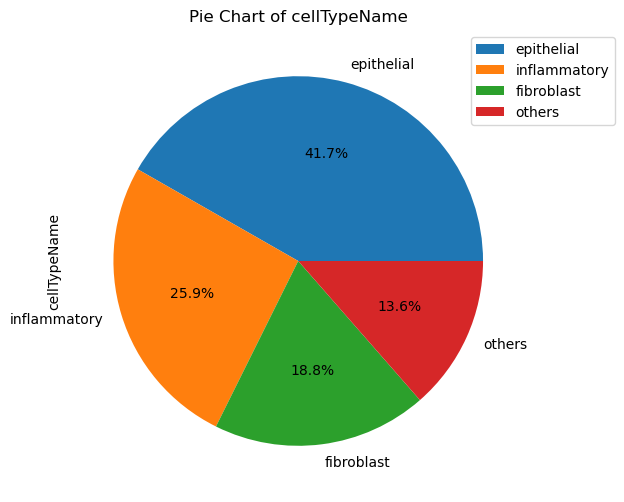

In [15]:
# Pie chart of cellTypeName

train_data['cellTypeName'].value_counts().plot(kind='pie',figsize=(15, 6),autopct='%1.1f%%')
plt.title("Pie Chart of cellTypeName")
plt.legend(bbox_to_anchor=(1.2, 1), loc='upper right')
plt.show()

[Text(0.5, 1.0, 'Count PLot of cellTypeName')]

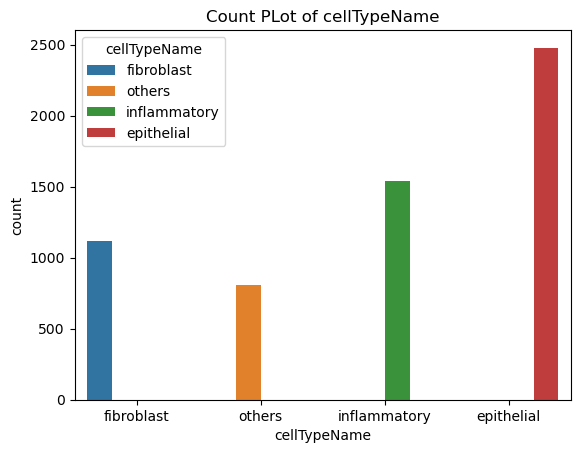

In [16]:
#Count PLot of cellTypeName
sns.countplot(x="cellTypeName",data=train_data,hue="cellTypeName").set(title="Count PLot of cellTypeName")

In [17]:
train_data['cellType'].value_counts()

2    2478
1    1539
0    1115
3     805
Name: cellType, dtype: int64

In this section, the training data is analyzed with respect to the cellType target column. The cellType column is an integer representation of cellTypeName column, which contains four categories: epithelial, inflammatory, fibroblast, and others. The value counts of the cellType column are computed and visualized using a pie chart and a count plot. From the pie chart, it can be observed that epithelial is the most common cell type in the training data with a percentage of 41.7%, followed by inflammatory with 25.9%, fibroblast with 18.8%, and others with 13.6%. 

In [18]:
train_data['isCancerous'].value_counts()

0    3459
1    2478
Name: isCancerous, dtype: int64

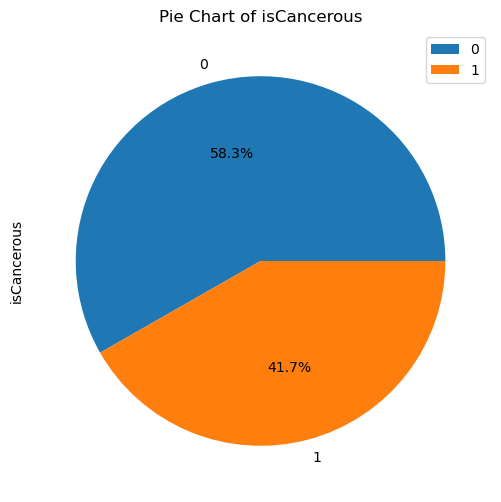

In [19]:
# Pie chart of isCancerous

train_data['isCancerous'].value_counts().plot(kind='pie',figsize=(15, 6),autopct='%1.1f%%')
plt.title("Pie Chart of isCancerous")
plt.legend( loc='upper right')
plt.show()

[Text(0.5, 1.0, 'Count PLot of isCancerous')]

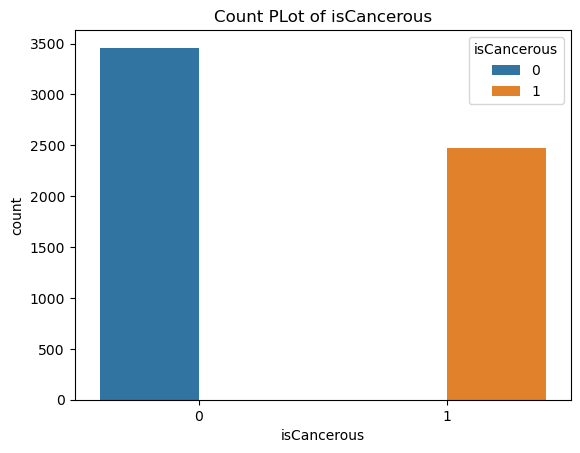

In [20]:
#Count PLot of cellTypeName
sns.countplot(x="isCancerous",data=train_data,hue="isCancerous").set(title="Count PLot of isCancerous")

The isCancerous column shows that the majority of the samples in the training set are non-cancerous, with a count of 3459 (58.3%). On the other hand, 2478 samples (41.7%) are labeled as cancerous. These findings are also reflected in the pie chart and count plot of the isCancerous column. This information is crucial for understanding the distribution of the target variable in the dataset, which can aid in developing a suitable model.

### Bivariate Data Analysis

In [21]:
cell_type_counts = train_data.groupby('patientID')['cellTypeName'].value_counts()
print(cell_type_counts)

patientID  cellTypeName
1          fibroblast       6
           inflammatory     2
           others           1
2          inflammatory    10
           fibroblast       4
                           ..
59         fibroblast       4
60         epithelial      32
           fibroblast      25
           inflammatory    15
           others           1
Name: cellTypeName, Length: 199, dtype: int64


In [22]:
cell_type_counts = cell_type_counts.reset_index(name='count')

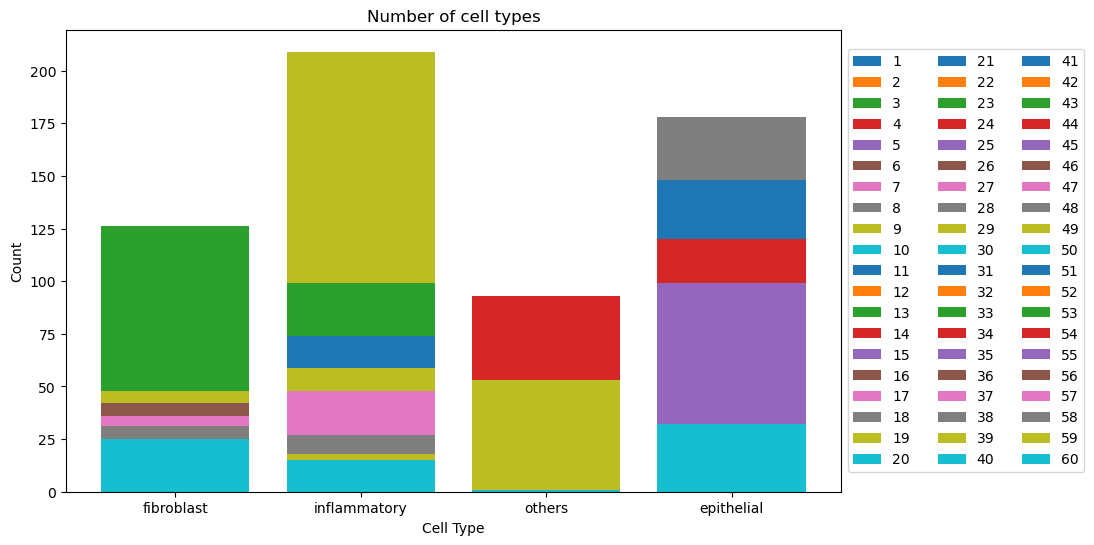

In [23]:
plt.figure(figsize=(10, 6))
for patient_id in cell_type_counts['patientID'].unique():
    patient_data = cell_type_counts[cell_type_counts['patientID'] == patient_id]
    plt.bar(patient_data['cellTypeName'], patient_data['count'], label=patient_id)

plt.xlabel('Cell Type')
plt.ylabel('Count')
plt.title('Number of cell types')
plt.legend(bbox_to_anchor=(1.0, 0.5), loc='center left', ncol=3)
plt.show()

### Pair Plot

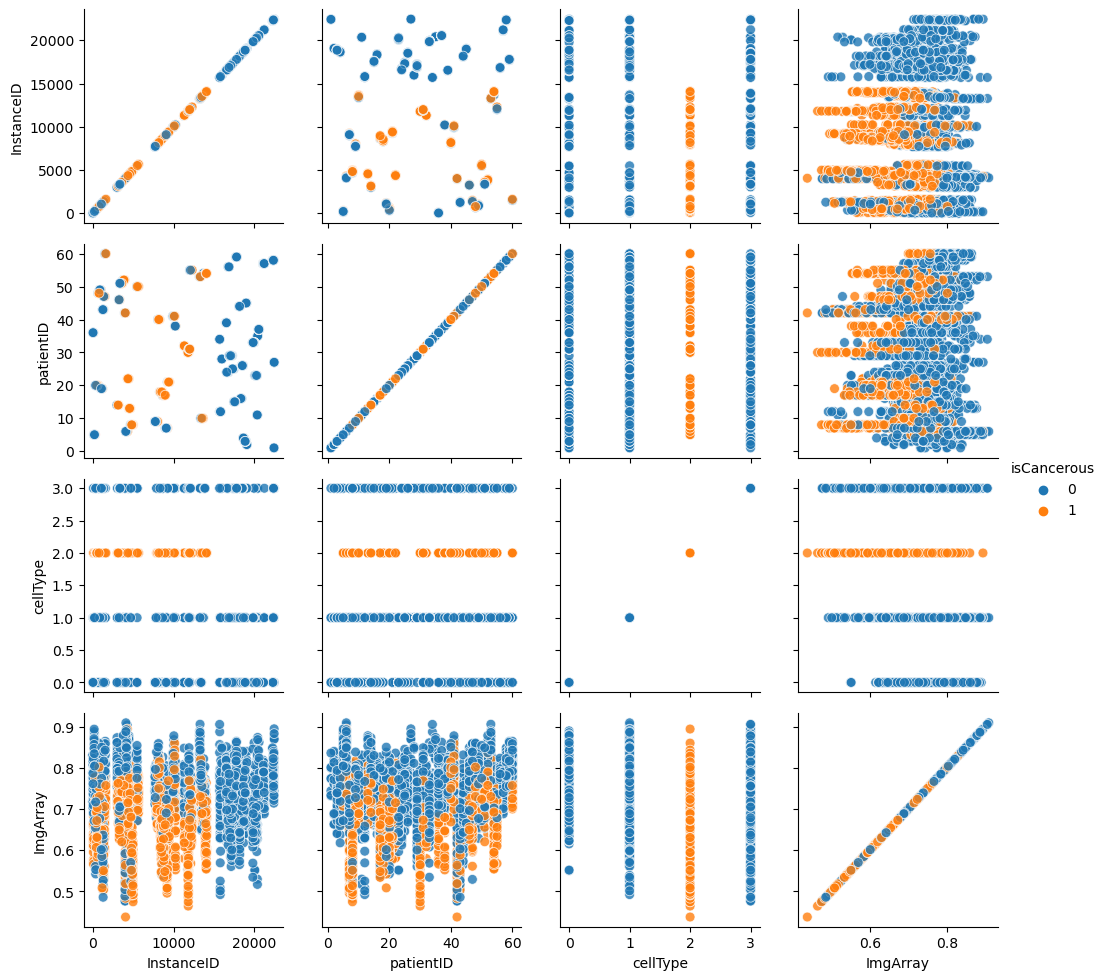

In [24]:
# To check how iscancerous is distributed
custom_palette = {0: 'green', 1: 'red'}
iscancerous_pairplot = sns.PairGrid(data=train_data, hue='isCancerous')
iscancerous_pairplot.map(sns.scatterplot, s=50, alpha=0.8,palette=custom_palette)
iscancerous_pairplot.add_legend()
plt.show()

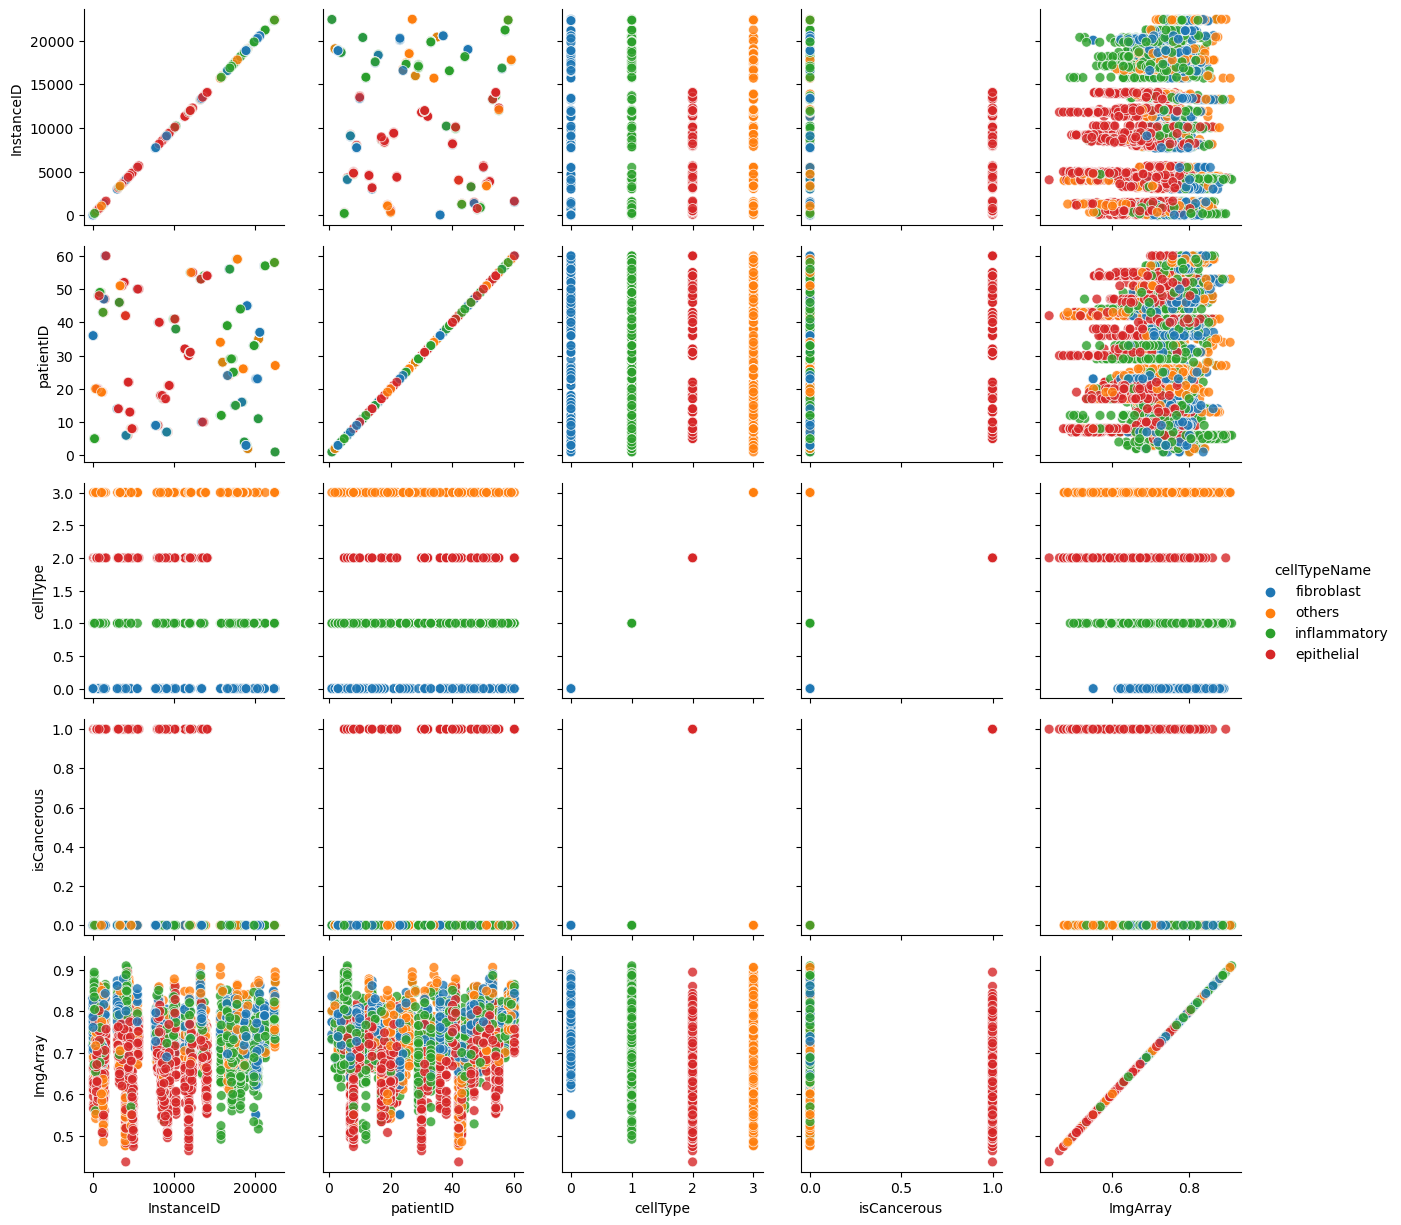

In [25]:
# To check how iscancerous is distributed

iscancerous_pairplot = sns.PairGrid(data=train_data, hue='cellTypeName')
iscancerous_pairplot.map(sns.scatterplot, s=50, alpha=0.8)
iscancerous_pairplot.add_legend()
plt.show()

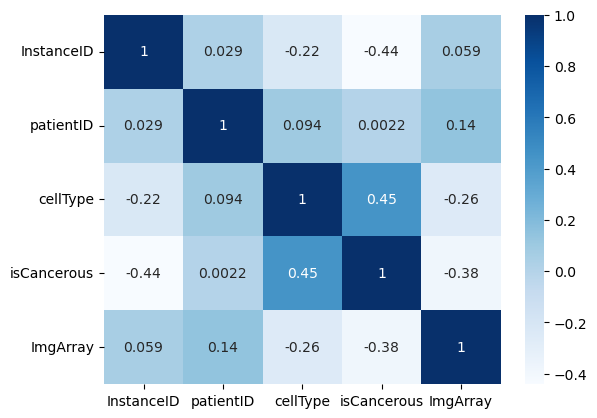

In [26]:
corr_train_data = train_data.corr(numeric_only=True)
sns.heatmap(corr_train_data, annot=True, cmap='Blues')
plt.show()

The heatmap generated from the correlation matrix of the training dataset shows that there is a positive correlation of 0.45 between the cellType and isCancerous columns, which are the two target variables. This suggests that there may be a relationship between these two variables in predicting cancerous cells.

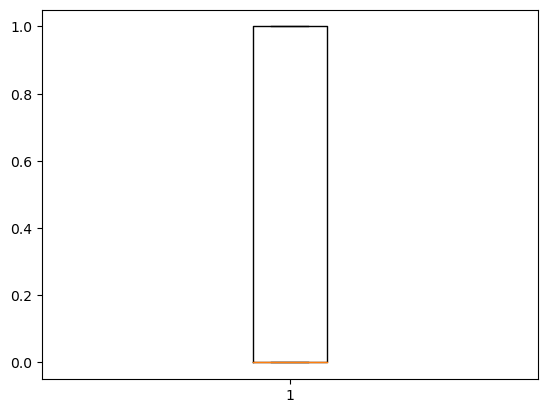

In [27]:
plt.boxplot(train_data['isCancerous'])
plt.show()

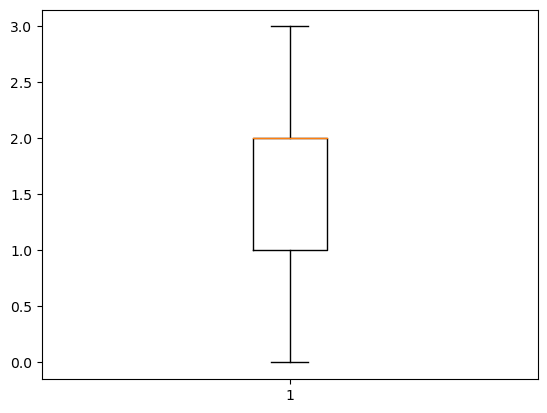

In [28]:
plt.boxplot(train_data['cellType'])
plt.show()

### Dividing into x attribute and y target

In [29]:
attribute_train = train_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImgArray'], axis=1)
target_train = train_data["cellTypeName"]
print(attribute_train)
print(target_train)

      patientID  ImageName  isCancerous
9533         58  22266.png            0
310           4  18717.png            0
9480         57  21202.png            0
7073         44  18114.png            0
8977         54  14070.png            1
...         ...        ...          ...
7872         50   5524.png            1
5624         31  11996.png            1
401           5    224.png            0
3394         19   1071.png            0
9349         56  16857.png            0

[5937 rows x 3 columns]
9533      fibroblast
310           others
9480    inflammatory
7073      fibroblast
8977      epithelial
            ...     
7872      epithelial
5624      epithelial
401     inflammatory
3394          others
9349    inflammatory
Name: cellTypeName, Length: 5937, dtype: object


In [30]:
attribute_train=attribute_train.reset_index()
target_train=target_train.reset_index()

### Observing cell

In [31]:
attribute_train.shape

(5937, 4)

In [32]:
img=plt.imread('./patch_images/' + attribute_train["ImageName"][0])
img.shape

(27, 27, 3)

In [33]:
red = img[:, :, 0]
green = img[:, :, 1]
blue = img[:, :, 2]

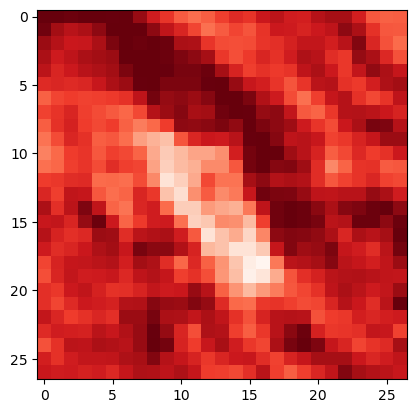

In [34]:
plt.imshow(red, cmap="Reds")
plt.show()

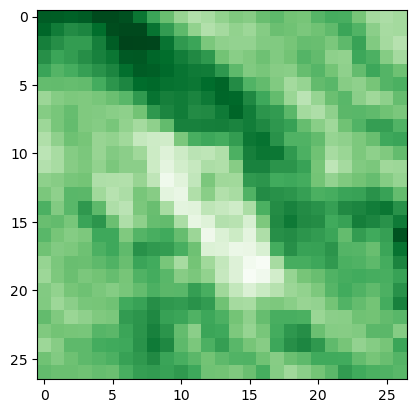

In [35]:
plt.imshow(green, cmap="Greens")
plt.show()

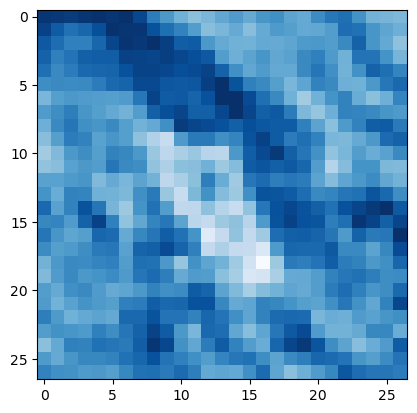

In [36]:
plt.imshow(blue, cmap="Blues")
plt.show()

### Original Image

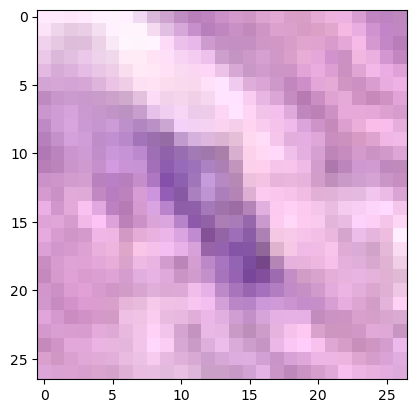

In [37]:
plt.imshow(img, cmap='gray')
plt.show()

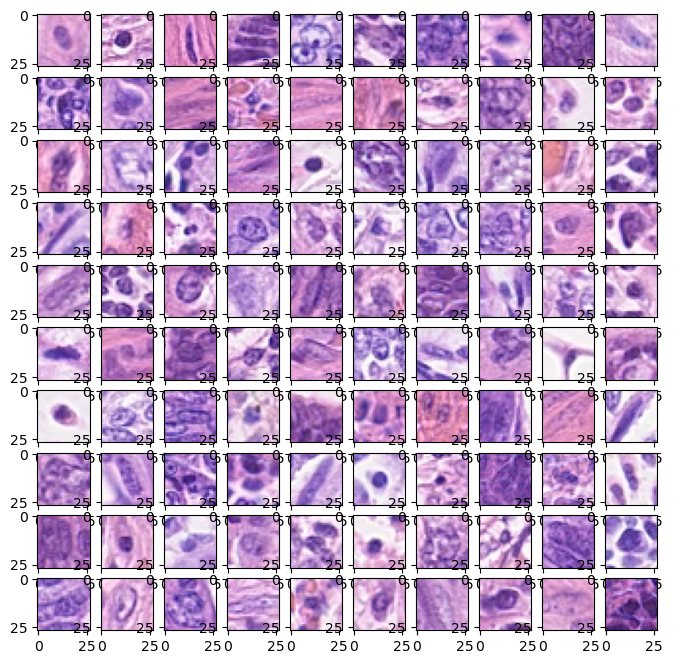

In [38]:
%matplotlib inline

columns = 10
rows = 10

fig=plt.figure(figsize=(8, 8))

for i in range(1, columns*rows + 1):
    img=plt.imread('./patch_images/' + attribute_train["ImageName"][i])
    fig.add_subplot(rows, columns, i)
    plt.imshow(img, cmap='gray')

plt.show()

## Functions

In [39]:
def plot_learning_curve(train_loss, val_loss, train_metric, val_metric, metric_name='Accuracy'):
    plt.figure(figsize=(10,5))
    
    plt.subplot(1,2,1)
    plt.plot(train_loss, 'r--')
    plt.plot(val_loss, 'b--')
    plt.xlabel("epochs")
    plt.ylabel("Loss")
    plt.legend(['train', 'val'], loc='upper left')

    plt.subplot(1,2,2)
    plt.plot(train_metric, 'r--')
    plt.plot(val_metric, 'b--')
    plt.xlabel("epochs")
    plt.ylabel(metric_name)
    plt.legend(['train', 'val'], loc='upper left')

    plt.show()

In [40]:
def evaluation(train,val,model):
    train_predictions = model.predict(train)
    validation_predictions = model.predict(val)
    train_predictions = model.predict(train)
    validation_predictions = model.predict(val)
    train_predicted_labels = np.argmax(train_predictions, axis=1)
    validation_predicted_labels = np.argmax(validation_predictions, axis=1)
    train_true_labels = train.classes
    validation_true_labels =val.classes
    train_report = classification_report(train_true_labels, train_predicted_labels)
    validation_report = classification_report(validation_true_labels, validation_predicted_labels)
    print("Training set classification report:\n", train_report)
    print("Validation set classification report:\n", validation_report)
    train_cm = confusion_matrix(train_true_labels, train_predicted_labels)
    validation_cm = confusion_matrix(validation_true_labels, validation_predicted_labels)

    plt.figure(figsize=(6, 3))
    plt.subplot(1, 2, 1)
    sns.heatmap(train_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title("Training Set Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.subplot(1, 2, 2)
    sns.heatmap(validation_cm, annot=True, cmap="Blues", fmt="d", cbar=False)
    plt.title("Validation Set Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    plt.tight_layout()
    plt.show()

# Target: isCancerous

## Data Pre-Processing

In [41]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 128
OUTPUT_CLASSES = 2

In [42]:
train_data['isCancerous'] = train_data['isCancerous'].astype('str')
val_data['isCancerous'] = val_data['isCancerous'].astype('str')
test_data['isCancerous'] = test_data['isCancerous'].astype('str')

In [43]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


## Train the Base model

This is the base model to predict isCancerous. Rest of the model will use similar format such as learning rate, epochs, and others to compare models at the same enviroment. One outstanding model will be selected for further hyperparameter tuning to improve the model further.

In [44]:
model_baseIC = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [45]:
model_baseIC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [46]:
history_baseIC = model_baseIC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

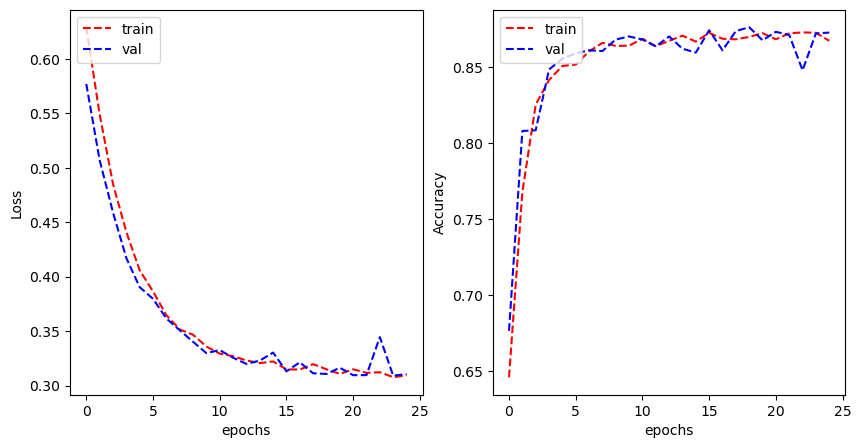

In [47]:
plot_learning_curve(history_baseIC.history['loss'], history_baseIC.history['val_loss'], 
                    history_baseIC.history['accuracy'], history_baseIC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [48]:
model_baseIC.evaluate(train_generator)
model_baseIC.evaluate(validation_generator)
model_baseIC.evaluate(test_generator)

62/62 [==============================] - 1s 9ms/step - loss: 0.3130 - accuracy: 0.8692


[0.31297120451927185, 0.8691919445991516]

62/62 [==============================] - 1s 9ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.58      0.60      0.59      3459
           1       0.42      0.40      0.41      2478

    accuracy                           0.51      5937
   macro avg       0.50      0.50      0.50      5937
weighted avg       0.51      0.51      0.51      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.59      0.62      0.60      1169
           1       0.41      0.39      0.40       810

    accuracy                           0.52      1979
   macro avg       0.50      0.50      0.50      1979
weighted avg       0.52      0.52      0.52      1979



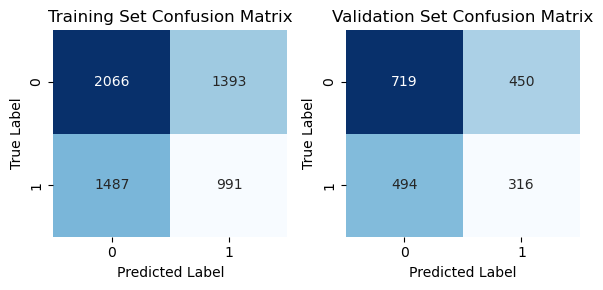

In [49]:
evaluation(train_generator, validation_generator, model_baseIC)

In [50]:
#Code to store the model and weights 
model_baseIC.save('output/baseIC.h5')
model_baseIC.save_weights('output/baseIC_weights.h5')

## Supervised Machine Learning Model

In [51]:
attribute_train_ML = train_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImageName','patientID','isCancerous'], axis=1)
target_train_ML = train_data["cellType"]
attribute_val_ML = val_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImageName','patientID','isCancerous'], axis=1)
target_val_ML = val_data["cellType"]
attribute_test_ML =test_data.drop(['cellTypeName', 'InstanceID', 'cellType','ImageName','patientID','isCancerous'], axis=1)
target_test_ML = test_data["cellType"]

### Logistic Regression

In [52]:
regression_model = LinearRegression()
regression_model.fit(attribute_train_ML ,target_train_ML)

LinearRegression()

In [53]:
for idx, col_name in enumerate(attribute_train_ML.columns):
    print("The coefficient for {} is {}".format(col_name, regression_model.coef_[idx]))

The coefficient for ImgArray is -3.366406202316284


In [54]:
intercept = regression_model.intercept_
print("The intercept for our model is {}".format(intercept))

The intercept for our model is 3.916517496109009


In [55]:
regression_model.score(attribute_train_ML ,target_train_ML)

0.06504547975439068

In [56]:
regression_model.score(attribute_test_ML, target_test_ML)

0.04827925750621964

# ResNet Model

In [57]:
model_ResNetIC = tf.keras.Sequential([
    tf.keras.layers.Conv2D(27, (7, 7), strides=(2, 2), padding='same', activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2, 2)),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),
  
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax'),
])

In [58]:
model_ResNetIC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [59]:
history_ResNetIC = model_ResNetIC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

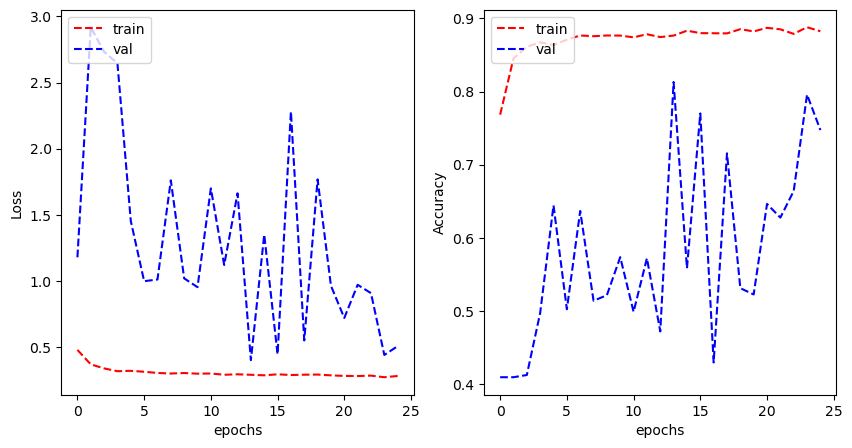

In [60]:
plot_learning_curve(history_ResNetIC.history['loss'], history_ResNetIC.history['val_loss'], 
                    history_ResNetIC.history['accuracy'],history_ResNetIC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [61]:
model_ResNetIC.evaluate(train_generator)
model_ResNetIC.evaluate(validation_generator)
model_ResNetIC.evaluate(test_generator)

62/62 [==============================] - 1s 18ms/step - loss: 0.4937 - accuracy: 0.7561


[0.49365484714508057, 0.7560606002807617]

62/62 [==============================] - 1s 15ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.59      0.35      0.44      3459
           1       0.42      0.66      0.51      2478

    accuracy                           0.48      5937
   macro avg       0.51      0.51      0.48      5937
weighted avg       0.52      0.48      0.47      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.60      0.35      0.44      1169
           1       0.41      0.67      0.51       810

    accuracy                           0.48      1979
   macro avg       0.51      0.51      0.48      1979
weighted avg       0.52      0.48      0.47      1979



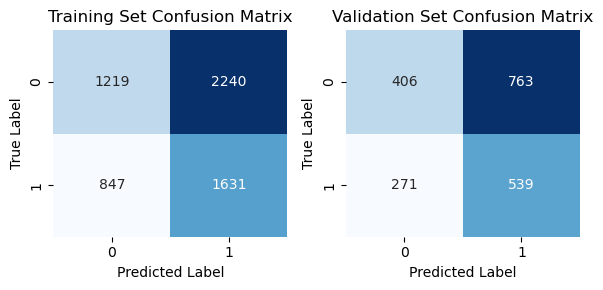

In [62]:
evaluation(train_generator, validation_generator, model_ResNetIC)

In [63]:
#Code to store the model and weights 
model_ResNetIC.save('output/ResNetIC.h5')
model_ResNetIC.save_weights('output/ResNetIC_weights.h5')

## VGG Model

VGG Model is tried using 2 blocks and 4 blocks as well. VGG with 4 blocks showed the highest accuracy but the graph showed overfittenss. Therefore, the next highest accuracy without showing overfitting model was VGG with 3 blocks which is the following

### VGG 3 Blocks

In [64]:
model_VGG3IC = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [65]:
model_VGG3IC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [66]:
history_VGG3IC = model_VGG3IC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

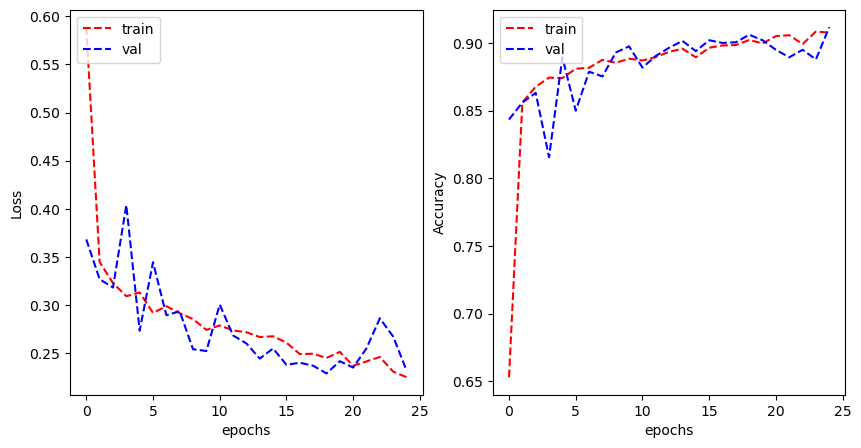

In [67]:
plot_learning_curve(history_VGG3IC.history['loss'], history_VGG3IC.history['val_loss'], 
                    history_VGG3IC.history['accuracy'], history_VGG3IC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [68]:
model_VGG3IC.evaluate(train_generator)
model_VGG3IC.evaluate(validation_generator)
model_VGG3IC.evaluate(test_generator)

62/62 [==============================] - 0s 7ms/step - loss: 0.2336 - accuracy: 0.9136


[0.2336350530385971, 0.9136363863945007]

62/62 [==============================] - 1s 8ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.59      0.60      0.59      3459
           1       0.43      0.42      0.42      2478

    accuracy                           0.52      5937
   macro avg       0.51      0.51      0.51      5937
weighted avg       0.52      0.52      0.52      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.60      0.60      0.60      1169
           1       0.42      0.41      0.42       810

    accuracy                           0.53      1979
   macro avg       0.51      0.51      0.51      1979
weighted avg       0.52      0.53      0.52      1979



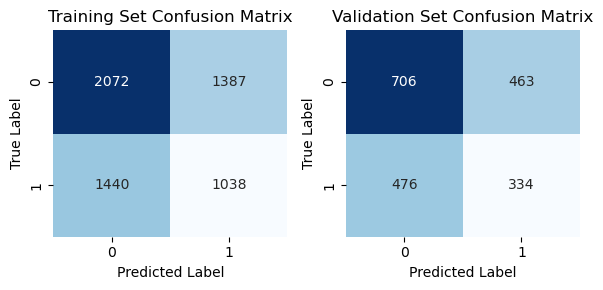

In [69]:
evaluation(train_generator, validation_generator, model_VGG3IC)

In [70]:
#Code to store the model and weights 
model_VGG3IC.save('output/VGG3IC.h5')
model_VGG3IC.save_weights('output/VGG3IC_weights.h5')

## CNN Model

CNN model was also tried with different number of layers from 2 to 4. The result was CNN with 4 layers model was showing the highest accuracy while CNN with 3 layers was showing the lowest. Thus, CNN with 4 layers is selected here as shown in the following

### CNN 4 Layers

In [71]:
model_CNN4IC = Sequential()
model_CNN4IC.add(Conv2D(26, kernel_size=(3, 3), activation='relu', input_shape=INPUT_DIM))
model_CNN4IC.add(BatchNormalization())

model_CNN4IC.add(Conv2D(26, kernel_size=(3, 3), activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN4IC.add(Dropout(0.25))

model_CNN4IC.add(Conv2D(52, kernel_size=(3, 3), activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN4IC.add(Dropout(0.25))

model_CNN4IC.add(Conv2D(104, kernel_size=(3, 3), activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(MaxPooling2D(pool_size=(2, 2)))
model_CNN4IC.add(Dropout(0.25))

model_CNN4IC.add(Flatten())

model_CNN4IC.add(Dense(512, activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(Dropout(0.5))

model_CNN4IC.add(Dense(128, activation='relu'))
model_CNN4IC.add(BatchNormalization())
model_CNN4IC.add(Dropout(0.5))

model_CNN4IC.add(Dense(OUTPUT_CLASSES, activation='sigmoid'))

In [72]:
model_CNN4IC.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                  metrics=['accuracy'])

In [73]:
history_CNN4IC = model_CNN4IC.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

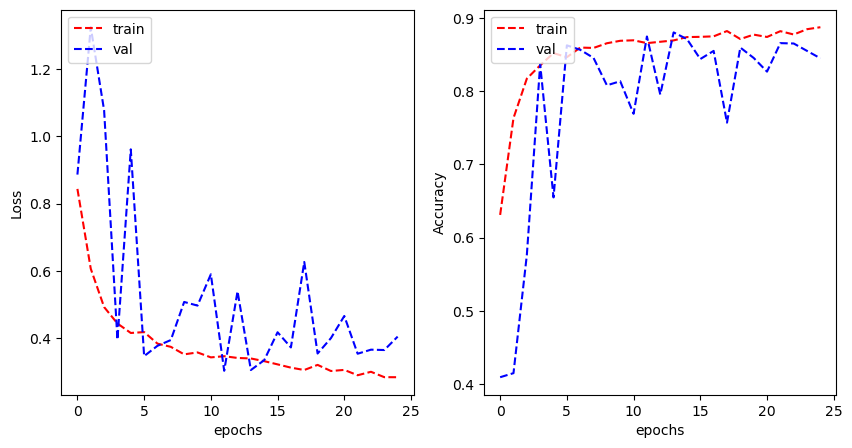

In [74]:
plot_learning_curve(history_CNN4IC.history['loss'], history_CNN4IC.history['val_loss'], 
                    history_CNN4IC.history['accuracy'], history_CNN4IC.history['val_accuracy'], 
                    metric_name='Accuracy')

In [75]:
model_CNN4IC.evaluate(train_generator)
model_CNN4IC.evaluate(validation_generator)
model_CNN4IC.evaluate(test_generator)

62/62 [==============================] - 1s 8ms/step - loss: 0.4071 - accuracy: 0.8444


[0.4071243703365326, 0.8444444537162781]

62/62 [==============================] - 1s 9ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.57      0.44      0.49      3459
           1       0.40      0.53      0.46      2478

    accuracy                           0.48      5937
   macro avg       0.49      0.49      0.48      5937
weighted avg       0.50      0.48      0.48      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.59      0.47      0.52      1169
           1       0.41      0.53      0.46       810

    accuracy                           0.49      1979
   macro avg       0.50      0.50      0.49      1979
weighted avg       0.52      0.49      0.50      1979



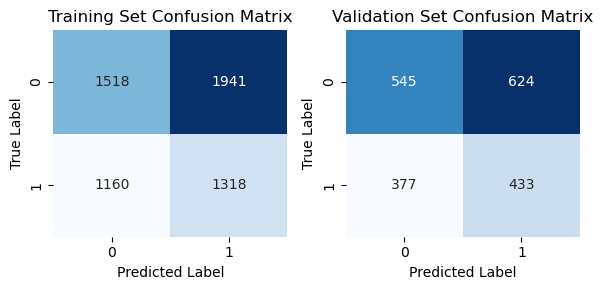

In [76]:
evaluation(train_generator, validation_generator, model_CNN4IC)

In [77]:
#Code to store the model and weights 
model_CNN4IC.save('output/CNN4IC.h5')
model_CNN4IC.save_weights('output/CNN4IC_weights.h5')

### Overall Result

In [78]:
baseIC = model_baseIC.evaluate(test_generator)[1]
LRIC = regression_model.score(attribute_test_ML, target_test_ML)
ResNetIC = model_ResNetIC.evaluate(test_generator)[1]
VGG3IC = model_VGG3IC.evaluate(test_generator)[1]
CNN4IC = model_CNN4IC.evaluate(test_generator)[1]

print("base: " + str(baseIC))
print("Logistic Regression: " + str(LRIC))
print("ResNet: " + str(ResNetIC))
print("VGG3: " + str(VGG3IC))
print("CNN4: " + str(CNN4IC))

62/62 [==============================] - 1s 9ms/step - loss: 0.4071 - accuracy: 0.8444
base: 0.8691919445991516
Logistic Regression: 0.04827925750621964
ResNet: 0.7560606002807617
VGG3: 0.9136363863945007
CNN4: 0.8444444537162781


Overall, only VGG model with 3 blocks showed better result compared to the baseline model while logistic regression, resnet and CNN with 4 layers showed poorer result. Thus, VGG model is selected for further hyperparameter tuning

In [79]:
model_VGG3IC.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_33 (Conv2D)          (None, 27, 27, 27)        756       
                                                                 
 conv2d_34 (Conv2D)          (None, 27, 27, 54)        13176     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 13, 13, 54)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 13, 13, 54)        0         
                                                                 
 conv2d_35 (Conv2D)          (None, 13, 13, 54)        26298     
                                                                 
 conv2d_36 (Conv2D)          (None, 13, 13, 108)       52596     
                                                      

## Hyperparameter Tuning

### Changing compiler parameter

In [80]:
model_ICCP = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [81]:
model_ICCP.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    decay=1e-6)
,loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),metrics=['accuracy'])

In [82]:
history_ICCP = model_ICCP.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

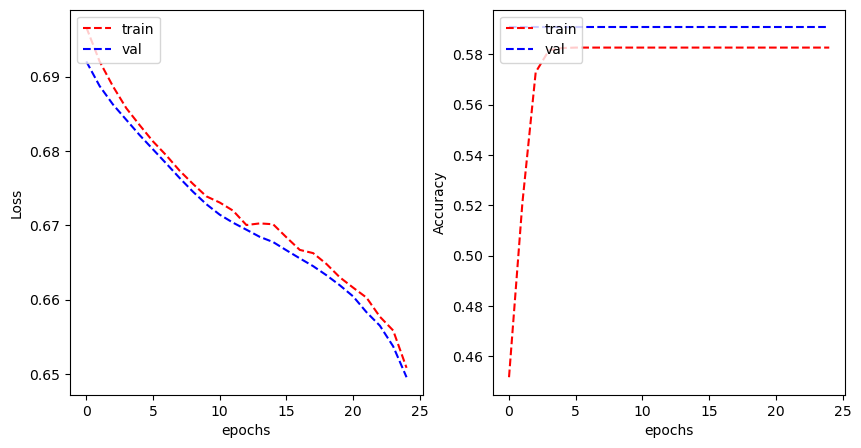

In [83]:
plot_learning_curve(history_ICCP.history['loss'], history_ICCP.history['val_loss'], 
                    history_ICCP.history['accuracy'], history_ICCP.history['val_accuracy'], 
                    metric_name='Accuracy')

In [84]:
model_ICCP.evaluate(train_generator)
model_ICCP.evaluate(validation_generator)
ICCP = model_ICCP.evaluate(test_generator)
print("VGG3: 0.9136363863945007")
print("ICCP: " + str(ICCP[1]))

62/62 [==============================] - 1s 8ms/step - loss: 0.6470 - accuracy: 0.6005
VGG3: 0.9136363863945007
ICCP: 0.6005050539970398


62/62 [==============================] - 0s 7ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.58      1.00      0.74      3459
           1       0.00      0.00      0.00      2478

    accuracy                           0.58      5937
   macro avg       0.29      0.50      0.37      5937
weighted avg       0.34      0.58      0.43      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.59      1.00      0.74      1169
           1       0.00      0.00      0.00       810

    accuracy                           0.59      1979
   macro avg       0.30      0.50      0.37      1979
weighted avg       0.35      0.59      0.44      1979



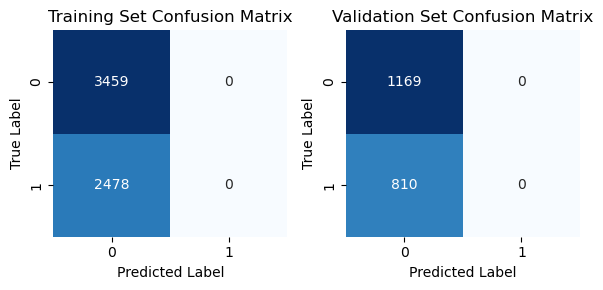

In [85]:
evaluation(train_generator, validation_generator, model_ICCP)

In [86]:
#Code to store the model and weights 
model_ICCP.save('output/ICCP.h5')
model_ICCP.save_weights('output/ICCP_weights.h5')

Although F1 score increased up to 59%, the confusion matrix shows that it only predicted 0 while there was no prediciton on 1. Changing compiler parameters didn't show great result compared to the original one. Thus, the complier parameters will be remain as it is.

### Using early stopping

In [87]:
model_ICES = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 3
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [88]:
model_ICES.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [89]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, min_delta=0.000001)

In [90]:
history_ICES = model_ICES.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0, callbacks=[callback])

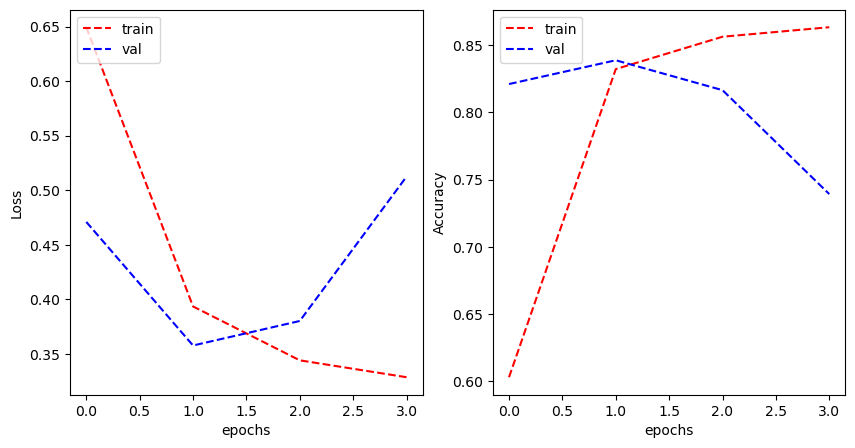

In [91]:
plot_learning_curve(history_ICES.history['loss'], history_ICES.history['val_loss'], 
                    history_ICES.history['accuracy'], history_ICES.history['val_accuracy'], 
                    metric_name='Accuracy')

In [92]:
model_ICES.evaluate(train_generator)
model_ICES.evaluate(validation_generator)
ICES = model_ICES.evaluate(test_generator)
print("VGG3: 0.9136363863945007")
print("ICES: " + str(ICES[1]))

62/62 [==============================] - 1s 10ms/step - loss: 0.3420 - accuracy: 0.8495
VGG3: 0.9136363863945007
ICES: 0.8494949340820312


62/62 [==============================] - 1s 8ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.58      0.47      0.52      3459
           1       0.41      0.52      0.46      2478

    accuracy                           0.49      5937
   macro avg       0.50      0.50      0.49      5937
weighted avg       0.51      0.49      0.50      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.58      0.47      0.52      1169
           1       0.40      0.50      0.44       810

    accuracy                           0.49      1979
   macro avg       0.49      0.49      0.48      1979
weighted avg       0.50      0.49      0.49      1979



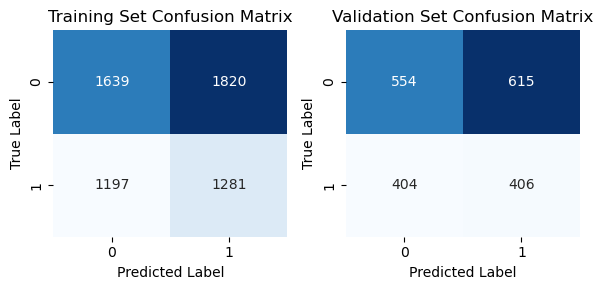

In [93]:
evaluation(train_generator, validation_generator, model_ICES)

In [94]:
#Code to store the model and weights 
model_ICES.save('output/ICES.h5')
model_ICES.save_weights('output/ICES_weights.h5')

Early stopping technique will not be used becasue it did not imporve the model.

### Epochs adjustment

In [95]:
def epochs_adjustment(epochs):
    model_ICEA = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 3
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model_ICEA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])
    
    history_ICEA = model_ICEA.fit(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)
    
    plot_learning_curve(history_ICEA.history['loss'], history_ICEA.history['val_loss'], 
                    history_ICEA.history['accuracy'], history_ICEA.history['val_accuracy'], 
                    metric_name='Accuracy')
    
    model_ICEA.evaluate(train_generator)
    model_ICEA.evaluate(validation_generator)
    test_acc = model_ICEA.evaluate(test_generator)
    print("VGG3: 0.9136363863945007")
    print("ICEA: " + str(test_acc[1]))
    
    evaluation(train_generator, validation_generator, model_ICEA)
    
    return test_acc[1], model_ICEA

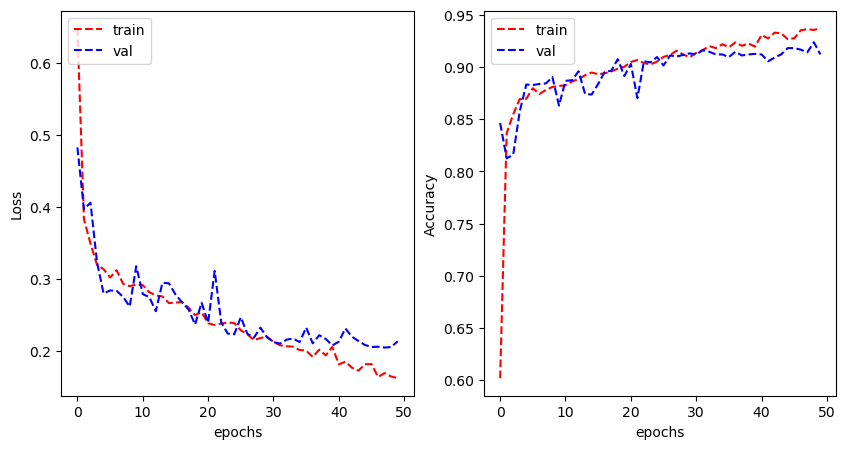

62/62 [==============================] - 0s 7ms/step - loss: 0.2256 - accuracy: 0.9136
VGG3: 0.9136363863945007
ICEA: 0.9136363863945007
62/62 [==============================] - 0s 7ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.58      0.61      0.59      3459
           1       0.41      0.38      0.39      2478

    accuracy                           0.51      5937
   macro avg       0.49      0.49      0.49      5937
weighted avg       0.51      0.51      0.51      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.60      0.63      0.62      1169
           1       0.43      0.40      0.41       810

    accuracy                           0.54      1979
   macro avg       0.52      0.51      0.51      1979
weighted avg       0.53      0.54      0.53      1979



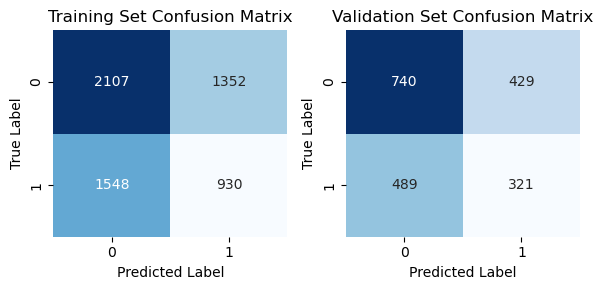

best_ICEA epochs=50 saved.


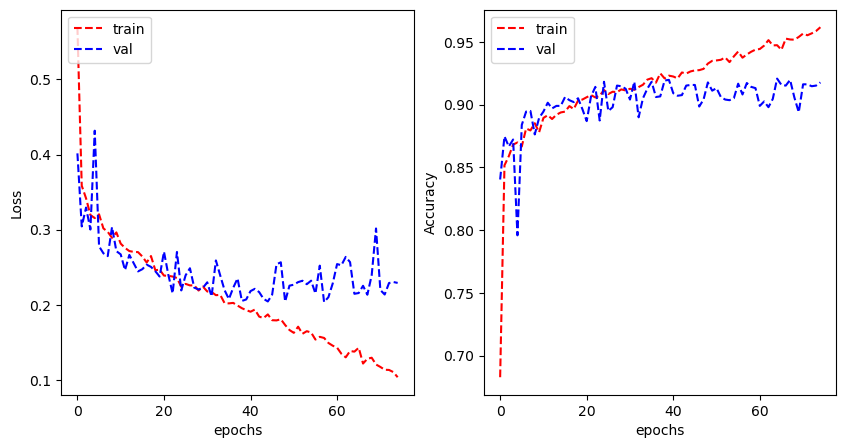

62/62 [==============================] - 0s 7ms/step - loss: 0.2536 - accuracy: 0.9131
VGG3: 0.9136363863945007
ICEA: 0.9131312966346741
62/62 [==============================] - 0s 7ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.57      0.58      0.58      3459
           1       0.40      0.40      0.40      2478

    accuracy                           0.50      5937
   macro avg       0.49      0.49      0.49      5937
weighted avg       0.50      0.50      0.50      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.60      0.61      0.60      1169
           1       0.43      0.42      0.42       810

    accuracy                           0.53      1979
   macro avg       0.51      0.51      0.51      1979
weighted avg       0.53      0.53      0.53      1979



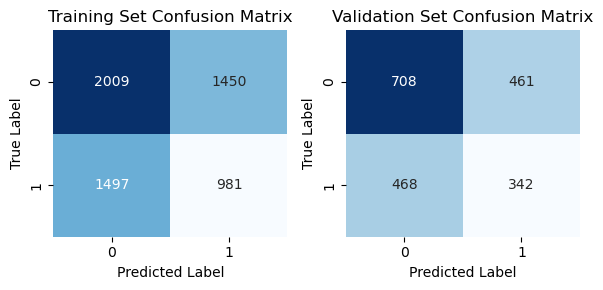

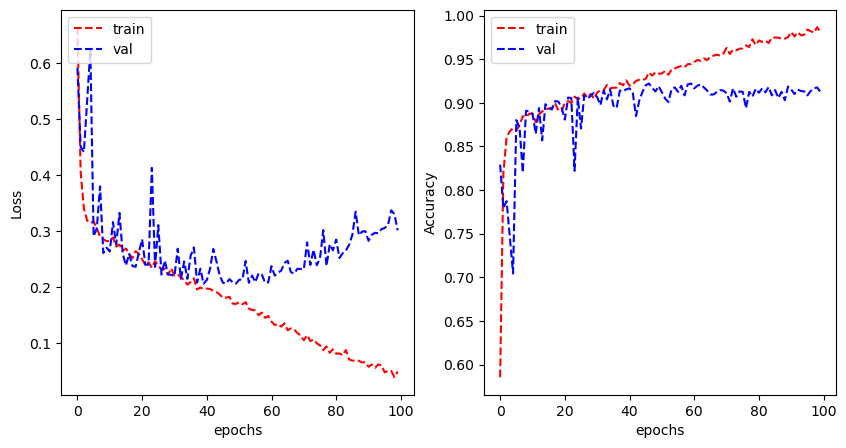

62/62 [==============================] - 0s 7ms/step - loss: 0.3359 - accuracy: 0.9146
VGG3: 0.9136363863945007
ICEA: 0.9146464467048645
62/62 [==============================] - 0s 7ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.59      0.59      0.59      3459
           1       0.43      0.43      0.43      2478

    accuracy                           0.52      5937
   macro avg       0.51      0.51      0.51      5937
weighted avg       0.52      0.52      0.52      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.60      0.59      0.59      1169
           1       0.43      0.44      0.43       810

    accuracy                           0.53      1979
   macro avg       0.51      0.51      0.51      1979
weighted avg       0.53      0.53      0.53      1979



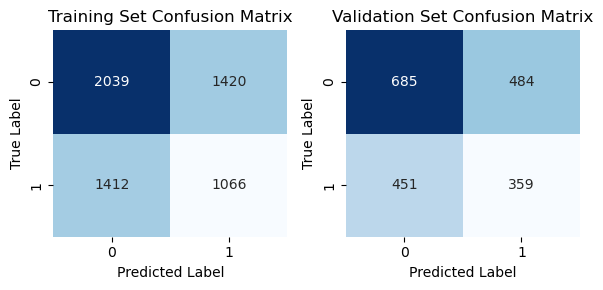

best_ICEA epochs=100 saved.


In [96]:
epochs_list = [50, 75, 100]
max_acc = 0
best_ICEA = None

for epochs in epochs_list:
    model_acc, model = epochs_adjustment(epochs)
    
    if model_acc > max_acc:
        max_acc = model_acc
        best_ICEA = model 
        print("best_ICEA epochs=" + str(epochs) + " saved.")
        
best_ICEA.save('output/ICEA.h5')
best_ICEA.save_weights('output/ICEA_weights.h5')

Although the highest accuracy is when epochs=100, it is showing overfitting as well as epochs=75. When epochs=50, the test accuracy is exactly the same as when epochs is 25. Thus, epochs will be set to 25 as it is showing less overfitness.

### Altering Lambda and Learning Rate

#### Regularizatoin

In [97]:
def parmeter_tuning(hp):
    Lambda = hp.Float("lambda", min_value=1e-5, max_value=1e2, sampling="log")

    model_ICLL = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM, kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 3
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu', kernel_regularizer=regularizers.l2(Lambda)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES, activation='sigmoid', kernel_regularizer=regularizers.l2(Lambda)),
    ])
    
    lr= hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model_ICLL.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                        loss=tf.keras.losses.BinaryCrossentropy(from_logits=False),
                        metrics=['accuracy'])
    
    return model_ICLL

In [98]:
parmeter_tuning(keras_tuner.HyperParameters())

In [99]:
tuner = keras_tuner.RandomSearch(
    hypermodel=parmeter_tuning,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="./patch_images/",
    project_name="Task1_ParameterTuning",
)

In [100]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
lambda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 100.0, 'step': None, 'sampling': 'log'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [101]:
tuner.search(train_generator, epochs=25, validation_data=validation_generator)

Trial 3 Complete [00h 04m 18s]
val_accuracy: 0.5907023549079895

Best val_accuracy So Far: 0.5907023549079895
Total elapsed time: 00h 12m 53s
INFO:tensorflow:Oracle triggered exit


In [102]:
tuner.results_summary()

Results summary
Results in ./patch_images/Task1_ParameterTuning
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 0 summary
Hyperparameters:
lambda: 0.047331796756916594
lr: 0.00032423906703069706
Score: 0.5907023549079895

Trial 1 summary
Hyperparameters:
lambda: 0.08324675111434068
lr: 0.0004888271752068167
Score: 0.5907023549079895

Trial 2 summary
Hyperparameters:
lambda: 0.2249021736277727
lr: 0.00010610861754866582
Score: 0.5907023549079895


- VGG3: 0.9136363863945007

The result shows that original parameter on learning rate and lambda is the best model.

Based on the hyperparameter tuned model, the following model is the final model with the highest accuracy to predict 'isCancerous'

## Final Model

In [103]:
train_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.15,
                                   rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 2 classes.
Found 1979 validated image filenames belonging to 2 classes.
Found 1980 validated image filenames belonging to 2 classes.


Data augmentation is applied to fix the overfitting since keras tuner only considers the highest val_accuracy without considering overfitness. 

In [104]:
model_ICFinal = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 3
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(216, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])

In [105]:
model_ICFinal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                  metrics=['accuracy'])

In [106]:
history_ICFinal = model_ICFinal.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

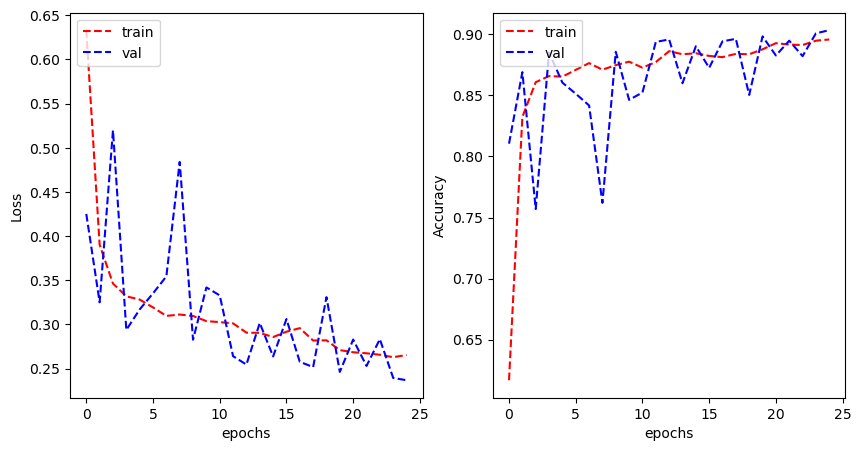

In [107]:
plot_learning_curve(history_ICFinal.history['loss'], history_ICFinal.history['val_loss'], 
                    history_ICFinal.history['accuracy'], history_ICFinal.history['val_accuracy'], 
                    metric_name='Accuracy')

In [108]:
model_ICFinal.evaluate(train_generator)
model_ICFinal.evaluate(validation_generator)
model_ICFinal.evaluate(test_generator)

62/62 [==============================] - 1s 21ms/step - loss: 0.2414 - accuracy: 0.9076


[0.24140460789203644, 0.907575786113739]

62/62 [==============================] - 1s 21ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58      3459
           1       0.42      0.44      0.43      2478

    accuracy                           0.51      5937
   macro avg       0.50      0.50      0.50      5937
weighted avg       0.52      0.51      0.52      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.59      0.57      0.58      1169
           1       0.41      0.43      0.42       810

    accuracy                           0.51      1979
   macro avg       0.50      0.50      0.50      1979
weighted avg       0.52      0.51      0.52      1979



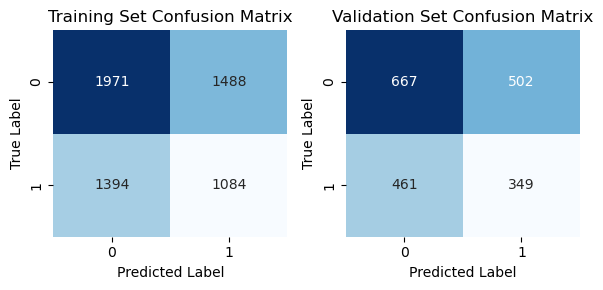

In [109]:
evaluation(train_generator, validation_generator, model_ICFinal)

In [110]:
#Code to store the model and weights 
model_ICFinal.save('output/ICFinal.h5')
model_ICFinal.save_weights('output/ICFinal_weights.h5')

## Predict isCancerous from test set

In [111]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="isCancerous",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 2 classes.


In [112]:
label_names = {'No' : 0, 'Yes' : 1}

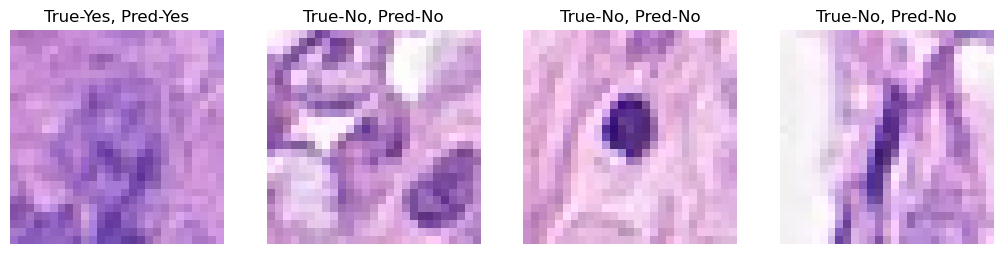

In [113]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(16,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_ICFinal.predict(x, verbose=0) # Change the model to the best one
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("True-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

# Target: CellTypeName

## Data Pre-Processing

In [114]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [115]:
train_data['cellTypeName'] = train_data['cellTypeName'].astype('str')
val_data['cellTypeName'] = val_data['cellTypeName'].astype('str')
test_data['cellTypeName'] = test_data['cellTypeName'].astype('str')

In [116]:
train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


## Train the Base model

In [117]:
model_baseCT = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(HIDDEN_LAYER_DIM, activation='sigmoid'),
    tf.keras.layers.Dense(OUTPUT_CLASSES)
])

In [118]:
model_baseCT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['categorical_accuracy'])

In [119]:
history_baseCT = model_baseCT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

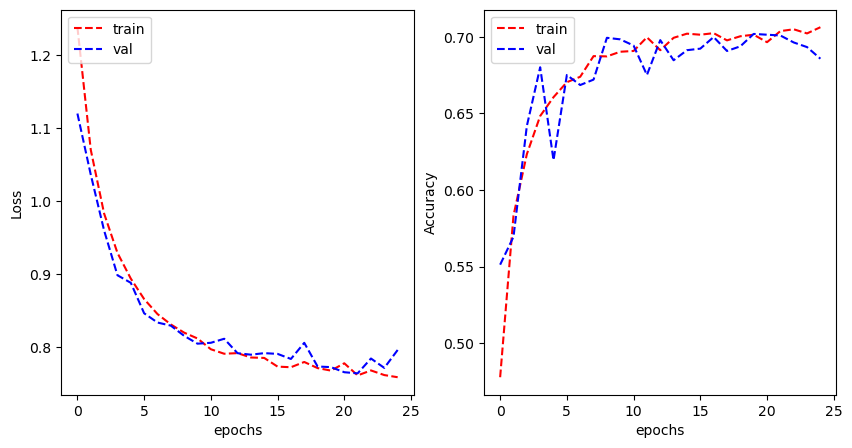

In [120]:
plot_learning_curve(history_baseCT.history['loss'], history_baseCT.history['val_loss'], 
                    history_baseCT.history['categorical_accuracy'], history_baseCT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [121]:
model_baseCT.evaluate(train_generator)
model_baseCT.evaluate(validation_generator)
model_baseCT.evaluate(test_generator)

62/62 [==============================] - 1s 8ms/step - loss: 0.8282 - categorical_accuracy: 0.6692


[0.8282089829444885, 0.6691918969154358]

62/62 [==============================] - 1s 9ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.41      0.43      0.42      2478
           1       0.17      0.12      0.14      1115
           2       0.25      0.25      0.25      1539
           3       0.14      0.20      0.17       805

    accuracy                           0.29      5937
   macro avg       0.25      0.25      0.24      5937
weighted avg       0.29      0.29      0.29      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.42      0.42       810
           1       0.17      0.12      0.14       382
           2       0.28      0.30      0.29       508
           3       0.15      0.18      0.16       279

    accuracy                           0.30      1979
   macro avg       0.25      0.25      0.25      1979
weighted avg       0.29      0.30      0.29      1979



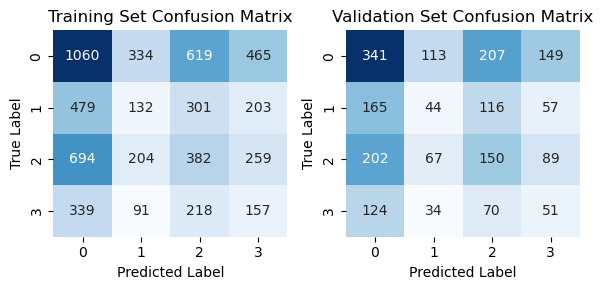

In [122]:
evaluation(train_generator, validation_generator, model_baseCT)

In [123]:
#Code to store the model and weights 
model_baseCT.save('output/baseCT.h5')
model_baseCT.save_weights('output/baseCT_weights.h5')

## Alex_Net Model

### Alex_Net

In [124]:
model_AlexNetCT = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(27, (11,11), strides=(4,4), activation='relu', input_shape=INPUT_DIM),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(54, (5,5), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(108, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(108, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.Conv2D(216, (3,3), strides=(1,1), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D((3, 3), strides=(2,2), padding='same'),
    tf.keras.layers.Dropout(0.25),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(432, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(432, activation='relu'),
    tf.keras.layers.Dropout(0.5),

    
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [125]:
model_AlexNetCT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [126]:
history_AlexNetCT = model_AlexNetCT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

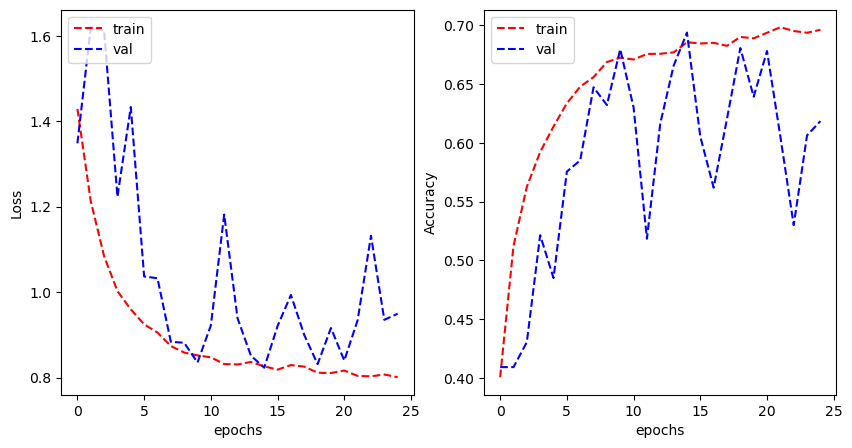

In [127]:
plot_learning_curve(history_AlexNetCT.history['loss'], history_AlexNetCT.history['val_loss'], 
                    history_AlexNetCT.history['categorical_accuracy'],history_AlexNetCT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [128]:
model_AlexNetCT.evaluate(train_generator)
model_AlexNetCT.evaluate(validation_generator)
model_AlexNetCT.evaluate(test_generator)

62/62 [==============================] - 0s 7ms/step - loss: 0.9808 - categorical_accuracy: 0.6106


[0.9808136224746704, 0.6106060743331909]

62/62 [==============================] - 0s 7ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.42      0.60      0.49      2478
           1       0.19      0.29      0.23      1115
           2       0.22      0.09      0.13      1539
           3       0.15      0.01      0.02       805

    accuracy                           0.33      5937
   macro avg       0.25      0.25      0.22      5937
weighted avg       0.29      0.33      0.28      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.59      0.48       810
           1       0.19      0.27      0.22       382
           2       0.24      0.11      0.15       508
           3       0.07      0.00      0.01       279

    accuracy                           0.32      1979
   macro avg       0.22      0.24      0.22      1979
weighted avg       0.27      0.32      0.28      1979



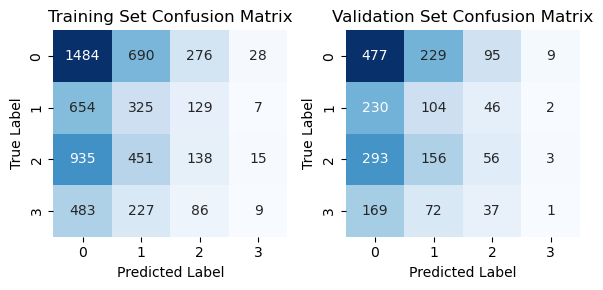

In [129]:
evaluation(train_generator, validation_generator, model_AlexNetCT)

In [130]:
#Code to store the model and weights 
model_AlexNetCT.save('output/AlexNetCT.h5')
model_AlexNetCT.save_weights('output/AlexNetCT_weights.h5')

## RCC_Net Model

In [131]:
model_RCCNetCT = Sequential()
model_RCCNetCT.add(Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=(27,27, 3)))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Conv2D(32, (3, 3), activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(MaxPooling2D(pool_size=(2, 2)))

model_RCCNetCT.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Conv2D(64, (3, 3), activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(MaxPooling2D(pool_size=(2, 2)))
model_RCCNetCT.add(Flatten())
model_RCCNetCT.add(Dense(512, activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Dropout(0.2))
model_RCCNetCT.add(Dense(512, activation='relu'))
model_RCCNetCT.add(BatchNormalization())
model_RCCNetCT.add(Dropout(0.2))
model_RCCNetCT.add(Dense(4, activation='softmax'))

In [132]:
model_RCCNetCT.compile(loss="categorical_crossentropy", metrics=["categorical_accuracy"], optimizer="adam")

In [133]:
history_RCCNetCT = model_RCCNetCT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

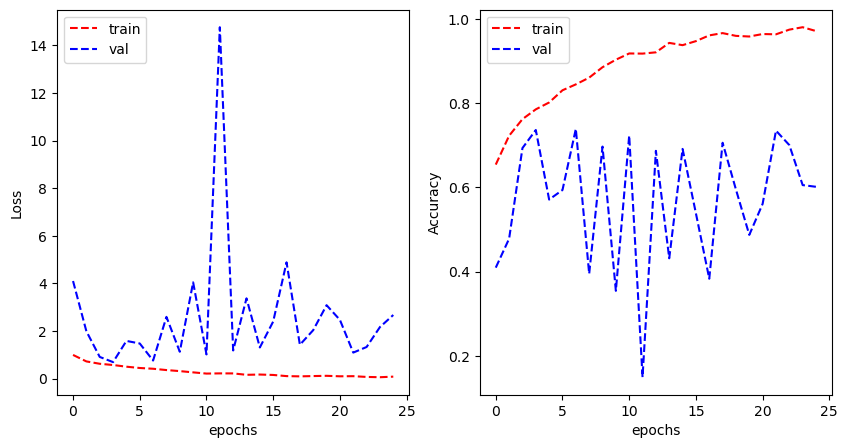

In [134]:
plot_learning_curve(history_RCCNetCT.history['loss'], history_RCCNetCT.history['val_loss'], 
                    history_RCCNetCT.history['categorical_accuracy'],history_RCCNetCT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [135]:
model_RCCNetCT.evaluate(train_generator)
model_RCCNetCT.evaluate(validation_generator)
model_RCCNetCT.evaluate(test_generator)

62/62 [==============================] - 1s 9ms/step - loss: 2.9393 - categorical_accuracy: 0.5747


[2.9393224716186523, 0.5747475028038025]

62/62 [==============================] - 0s 7ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.44      0.31      0.37      2478
           1       0.18      0.35      0.24      1115
           2       0.27      0.18      0.22      1539
           3       0.15      0.19      0.16       805

    accuracy                           0.27      5937
   macro avg       0.26      0.26      0.25      5937
weighted avg       0.31      0.27      0.28      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.42      0.30      0.35       810
           1       0.20      0.42      0.27       382
           2       0.25      0.14      0.18       508
           3       0.12      0.14      0.13       279

    accuracy                           0.26      1979
   macro avg       0.25      0.25      0.23      1979
weighted avg       0.29      0.26      0.26      1979



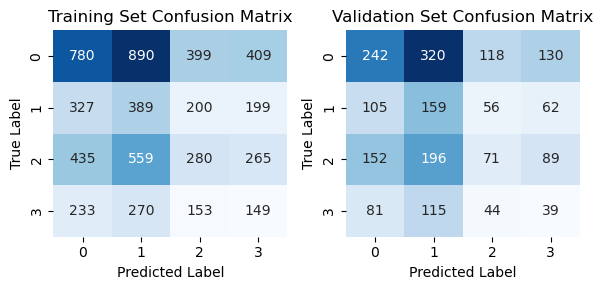

In [136]:
evaluation(train_generator, validation_generator, model_RCCNetCT)

In [137]:
#Code to store the model and weights 
model_RCCNetCT.save('output/RCCNetCT.h5')
model_RCCNetCT.save_weights('output/RCCNetCT_weights.h5')

## VGG Model

Unlike VGG model for isCancerous, VGG model for cellTypeName with 2 Blocks showed the highest accuracy followed by 3 blocks and 4 blocks.

### VGG 2 Blocks

In [138]:
model_VGG2CT = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [139]:
model_VGG2CT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [140]:
history_VGG2CT = model_VGG2CT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

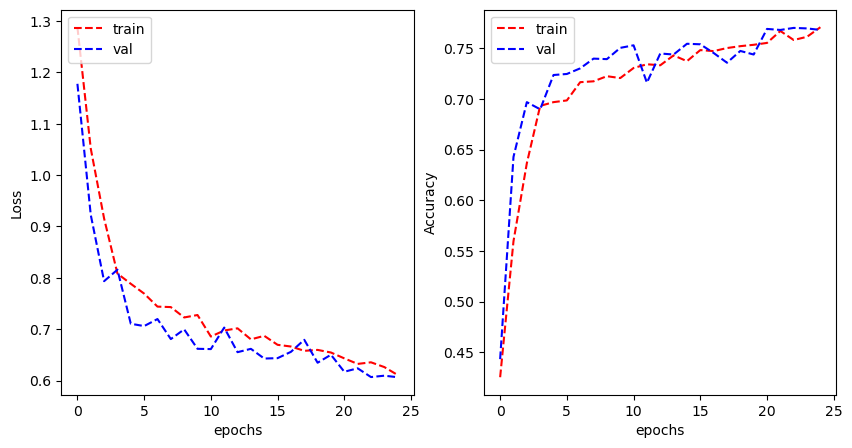

In [141]:
plot_learning_curve(history_VGG2CT.history['loss'], history_VGG2CT.history['val_loss'], 
                    history_VGG2CT.history['categorical_accuracy'], history_VGG2CT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [142]:
model_VGG2CT.evaluate(train_generator)
model_VGG2CT.evaluate(validation_generator)
model_VGG2CT.evaluate(test_generator)

62/62 [==============================] - 1s 10ms/step - loss: 0.6542 - categorical_accuracy: 0.7551


[0.654184877872467, 0.7550504803657532]

62/62 [==============================] - 1s 10ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.43      0.43      0.43      2478
           1       0.18      0.17      0.17      1115
           2       0.27      0.35      0.30      1539
           3       0.11      0.06      0.08       805

    accuracy                           0.31      5937
   macro avg       0.25      0.25      0.25      5937
weighted avg       0.30      0.31      0.30      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.40      0.40      0.40       810
           1       0.15      0.13      0.14       382
           2       0.27      0.38      0.32       508
           3       0.10      0.05      0.07       279

    accuracy                           0.29      1979
   macro avg       0.23      0.24      0.23      1979
weighted avg       0.28      0.29      0.28      1979



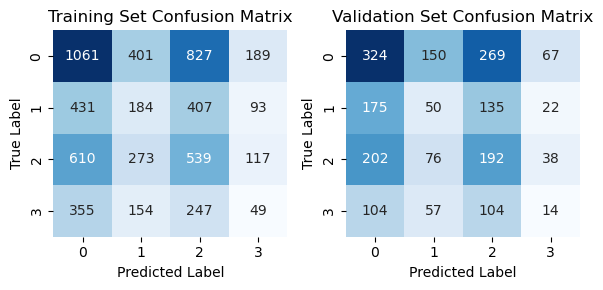

In [143]:
evaluation(train_generator, validation_generator, model_VGG2CT)

In [144]:
#Code to store the model and weights 
model_VGG2CT.save('output/VGG2CT.h5')
model_VGG2CT.save_weights('output/VGG2CT_weights.h5')

## ANN Model

For ANN model, from 1 to 3 layers are tested and ANN model with 3 hidden layers showed the best result.

### ANN 3 Hidden Layers

In [145]:
model_ANN3CT = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=INPUT_DIM),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(OUTPUT_CLASSES, activation='softmax')
])

In [146]:
model_ANN3CT.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                  metrics=['categorical_accuracy'])

In [147]:
history_ANN3CT = model_ANN3CT.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

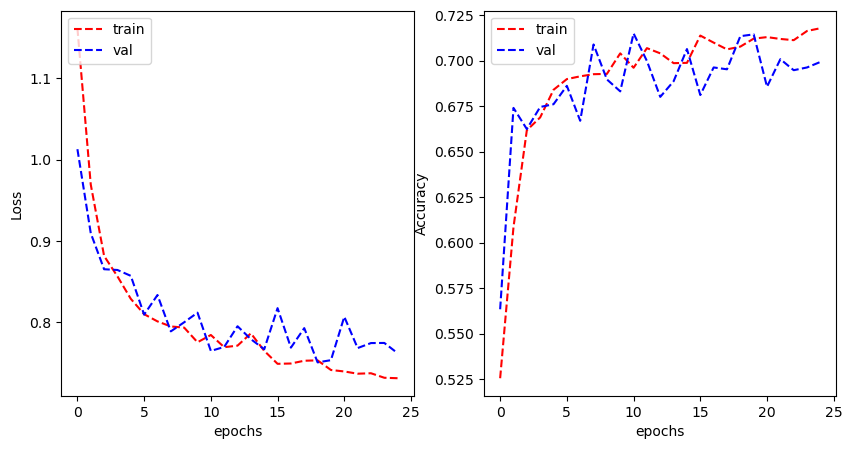

In [148]:
plot_learning_curve(history_ANN3CT.history['loss'], history_ANN3CT.history['val_loss'], 
                    history_ANN3CT.history['categorical_accuracy'], history_ANN3CT.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [149]:
model_ANN3CT.evaluate(train_generator)
model_ANN3CT.evaluate(validation_generator)
model_ANN3CT.evaluate(test_generator)

62/62 [==============================] - 0s 6ms/step - loss: 0.7918 - categorical_accuracy: 0.6995


[0.7917701601982117, 0.6994949579238892]

62/62 [==============================] - 0s 6ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.42      0.52      0.46      2478
           1       0.20      0.24      0.22      1115
           2       0.26      0.24      0.25      1539
           3       0.14      0.03      0.04       805

    accuracy                           0.33      5937
   macro avg       0.25      0.26      0.24      5937
weighted avg       0.30      0.33      0.31      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.49      0.44       810
           1       0.20      0.23      0.21       382
           2       0.25      0.25      0.25       508
           3       0.12      0.02      0.03       279

    accuracy                           0.31      1979
   macro avg       0.24      0.25      0.23      1979
weighted avg       0.28      0.31      0.29      1979



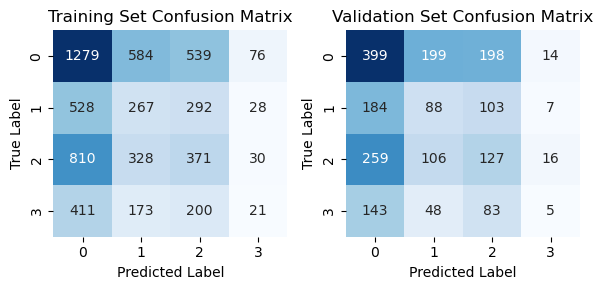

In [150]:
evaluation(train_generator, validation_generator, model_ANN3CT)

In [151]:
#Code to store the model and weights 
model_ANN3CT.save('output/ANN3CT.h5')
model_ANN3CT.save_weights('output/ANN3CT_weights.h5')

### Overall Result

In [152]:
baseCT = model_baseCT.evaluate(test_generator)[1]
AlexNetCT = model_AlexNetCT.evaluate(test_generator)[1]
RCCNetCT = model_RCCNetCT.evaluate(test_generator)[1]
VGG2CT = model_VGG2CT.evaluate(test_generator)[1]
ANN3CT = model_ANN3CT.evaluate(test_generator)[1]

print("base: " + str(baseCT))
print("AlexNet: " + str(AlexNetCT))
print("RCCNet: " + str(RCCNetCT))
print("VGG2: " + str(VGG2CT))
print("ANN3: " + str(ANN3CT))

62/62 [==============================] - 0s 6ms/step - loss: 0.7918 - categorical_accuracy: 0.6995
base: 0.6691918969154358
AlexNet: 0.6106060743331909
RCCNet: 0.5747475028038025
VGG2: 0.7550504803657532
ANN3: 0.6994949579238892


The result shows that alexnet and RCCnet showed poor performance compared to the baseline model while VGG and ANN model showed better performance. Among those two models, VGG with 2 blocks again showed outstanding result and selected for further hyperparameter tuning.

In [153]:
model_VGG2CT.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_21 (Conv2D)          (None, 27, 27, 27)        756       
                                                                 
 conv2d_22 (Conv2D)          (None, 27, 27, 54)        13176     
                                                                 
 max_pooling2d_11 (MaxPoolin  (None, 13, 13, 54)       0         
 g2D)                                                            
                                                                 
 dropout_15 (Dropout)        (None, 13, 13, 54)        0         
                                                                 
 conv2d_23 (Conv2D)          (None, 13, 13, 54)        26298     
                                                                 
 conv2d_24 (Conv2D)          (None, 13, 13, 108)       52596     
                                                      

## Hyperparameters Tuning

### Changing compiler parameter

In [154]:
model_CTCP = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [155]:
model_CTCP.compile(optimizer=tf.keras.optimizers.SGD(
    learning_rate=0.0001,
    momentum=0.9,
    decay=1e-6)
,loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),metrics=['categorical_accuracy'])

In [156]:
history_CTCP = model_CTCP.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

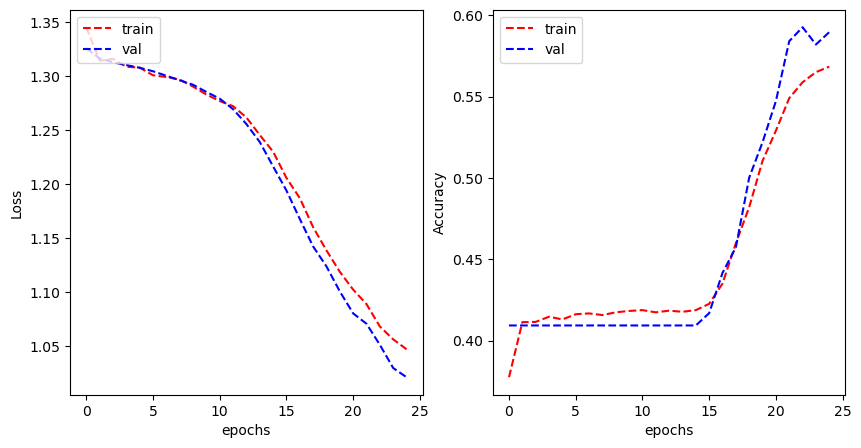

In [157]:
plot_learning_curve(history_CTCP.history['loss'], history_CTCP.history['val_loss'], 
                    history_CTCP.history['categorical_accuracy'], history_CTCP.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [158]:
model_CTCP.evaluate(train_generator)
model_CTCP.evaluate(validation_generator)
CTCP = model_CTCP.evaluate(test_generator)
print("VGG2: 0.7550504803657532")
print("CTCP: " + str(CTCP[1]))

62/62 [==============================] - 1s 10ms/step - loss: 1.0365 - categorical_accuracy: 0.5985
VGG2: 0.7550504803657532
CTCP: 0.5984848737716675


62/62 [==============================] - 1s 12ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.41      0.51      0.46      2478
           1       0.17      0.21      0.19      1115
           2       0.26      0.25      0.25      1539
           3       0.00      0.00      0.00       805

    accuracy                           0.32      5937
   macro avg       0.21      0.24      0.22      5937
weighted avg       0.27      0.32      0.29      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.51      0.45       810
           1       0.19      0.24      0.21       382
           2       0.28      0.27      0.28       508
           3       0.00      0.00      0.00       279

    accuracy                           0.32      1979
   macro avg       0.22      0.26      0.24      1979
weighted avg       0.28      0.32      0.30      1979



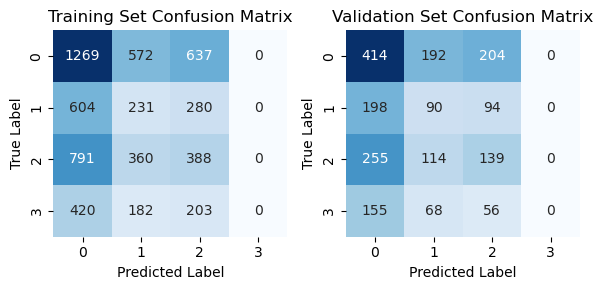

In [159]:
evaluation(train_generator, validation_generator, model_CTCP)

In [160]:
#Code to store the model and weights 
model_CTCP.save('output/CTCP.h5')
model_CTCP.save_weights('output/CTCP_weights.h5')

The shows that the compiler parameter tuning doesn't improve the model

### Using earlystopping

In [161]:
model_CTES = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [162]:
model_CTES.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [163]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True, min_delta=0.000001)

In [164]:
history_CTES = model_CTES.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0, callbacks=[callback])

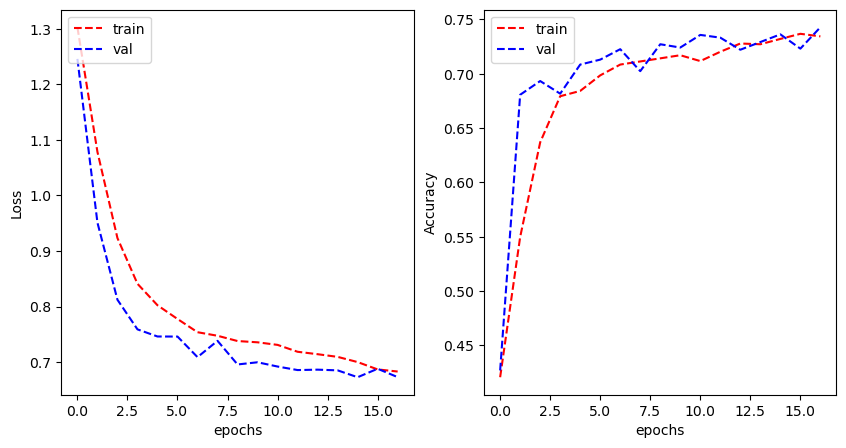

In [165]:
plot_learning_curve(history_CTES.history['loss'], history_CTES.history['val_loss'], 
                    history_CTES.history['categorical_accuracy'], history_CTES.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [166]:
model_CTES.evaluate(train_generator)
model_CTES.evaluate(validation_generator)
CTES = model_CTES.evaluate(test_generator)
print("VGG2: 0.7550504803657532")
print("CTES: " + str(CTES[1]))

62/62 [==============================] - 1s 10ms/step - loss: 0.6944 - categorical_accuracy: 0.7318
VGG2: 0.7550504803657532
CTES: 0.7318181991577148


62/62 [==============================] - 1s 10ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.42      0.48      0.45      2478
           1       0.19      0.19      0.19      1115
           2       0.26      0.31      0.28      1539
           3       0.12      0.03      0.04       805

    accuracy                           0.32      5937
   macro avg       0.25      0.25      0.24      5937
weighted avg       0.30      0.32      0.30      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.46      0.43       810
           1       0.17      0.16      0.16       382
           2       0.24      0.29      0.26       508
           3       0.21      0.05      0.08       279

    accuracy                           0.30      1979
   macro avg       0.26      0.24      0.23      1979
weighted avg       0.29      0.30      0.29      1979



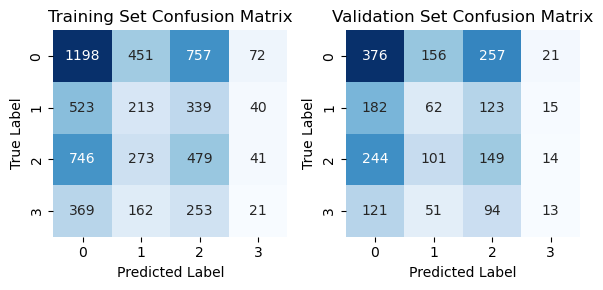

In [167]:
evaluation(train_generator, validation_generator, model_CTES)

In [168]:
#Code to store the model and weights 
model_CTES.save('output/CTES.h5')
model_CTES.save_weights('output/CTES_weights.h5')

The result shows early stopping doesn't improve model

### Epochs adjustment

In [171]:
def epochs_adjustment(epochs):
    model_ICEA = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    model_ICEA.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])
    
    history_ICEA = model_ICEA.fit(train_generator, validation_data = validation_generator, epochs=epochs, verbose=0)
    
    plot_learning_curve(history_ICEA.history['loss'], history_ICEA.history['val_loss'], 
                    history_ICEA.history['categorical_accuracy'], history_ICEA.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')
    
    model_ICEA.evaluate(train_generator)
    model_ICEA.evaluate(validation_generator)
    test_acc = model_ICEA.evaluate(test_generator)
    print("VGG2: 0.7550504803657532")
    print("ICEA: " + str(test_acc[1]))
    
    evaluation(train_generator, validation_generator, model_ICEA)
    
    return test_acc[1], model_ICEA

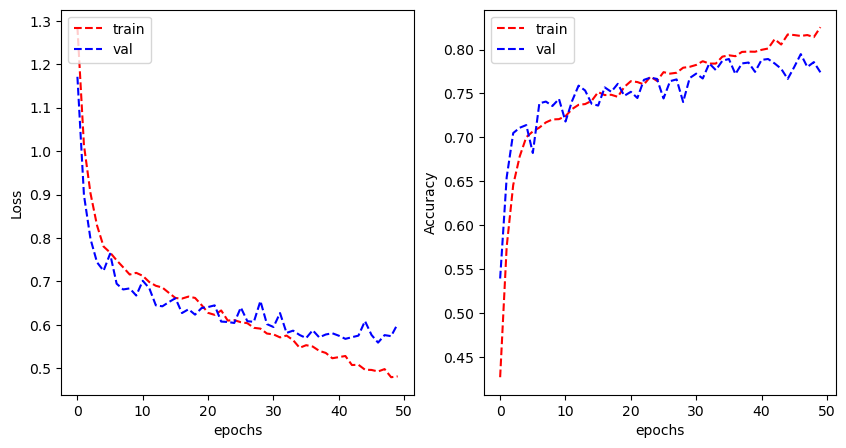

62/62 [==============================] - 1s 10ms/step - loss: 0.6528 - categorical_accuracy: 0.7586
VGG2: 0.7550504803657532
ICEA: 0.7585858702659607
62/62 [==============================] - 1s 8ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.43      0.38      0.40      2478
           1       0.19      0.20      0.19      1115
           2       0.27      0.32      0.29      1539
           3       0.15      0.13      0.14       805

    accuracy                           0.30      5937
   macro avg       0.26      0.26      0.26      5937
weighted avg       0.30      0.30      0.30      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.37      0.39       810
           1       0.18      0.18      0.18       382
           2       0.26      0.32      0.29       508
           3       0.15      0.13      0.14       279

    accuracy  

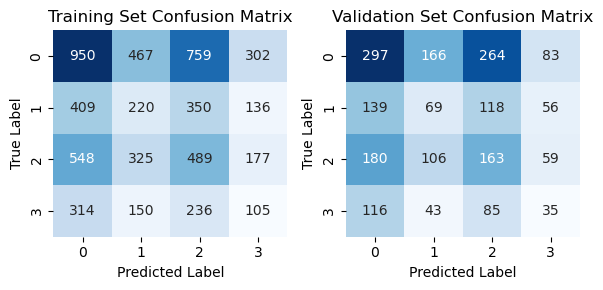

best_ICEA epochs=50 saved.


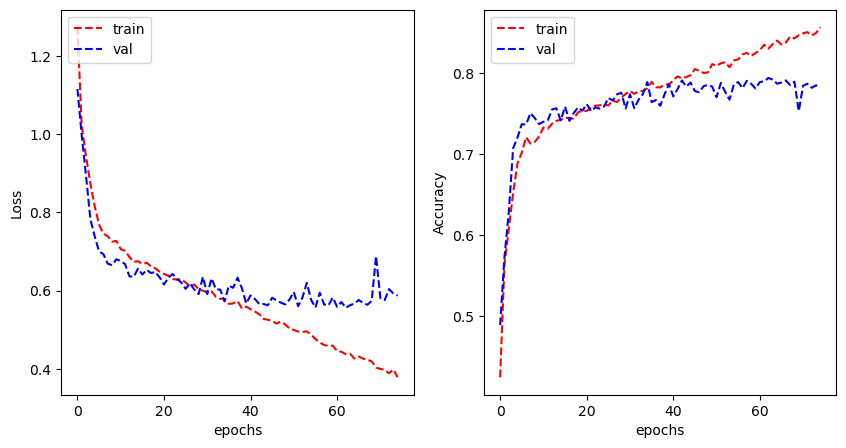

62/62 [==============================] - 1s 9ms/step - loss: 0.6450 - categorical_accuracy: 0.7667
VGG2: 0.7550504803657532
ICEA: 0.7666666507720947
62/62 [==============================] - 1s 8ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.42      0.43      0.42      2478
           1       0.17      0.18      0.18      1115
           2       0.26      0.27      0.27      1539
           3       0.12      0.09      0.10       805

    accuracy                           0.30      5937
   macro avg       0.24      0.24      0.24      5937
weighted avg       0.29      0.30      0.29      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.43      0.44      0.44       810
           1       0.22      0.23      0.22       382
           2       0.25      0.28      0.26       508
           3       0.14      0.08      0.10       279

    accuracy   

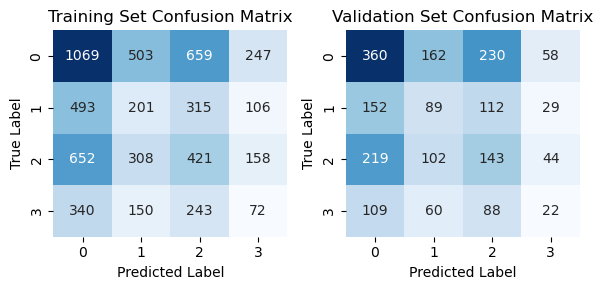

best_ICEA epochs=75 saved.


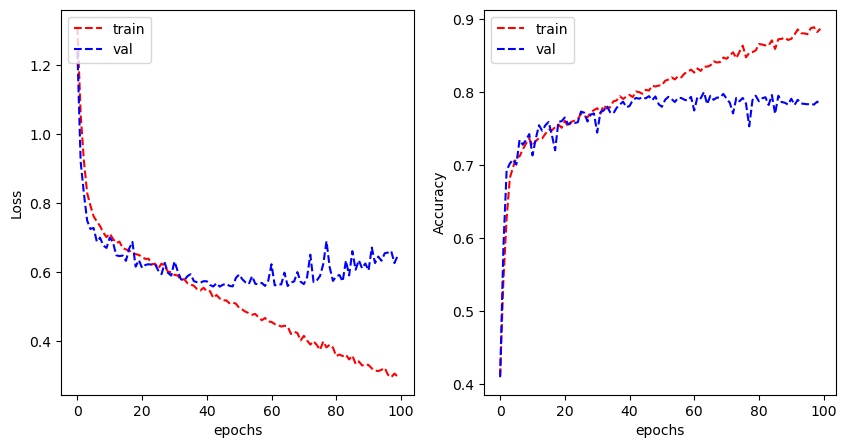

62/62 [==============================] - 0s 7ms/step - loss: 0.6985 - categorical_accuracy: 0.7702
VGG2: 0.7550504803657532
ICEA: 0.7702020406723022
62/62 [==============================] - 1s 8ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.43      0.44      0.43      2478
           1       0.21      0.19      0.20      1115
           2       0.26      0.28      0.27      1539
           3       0.12      0.11      0.11       805

    accuracy                           0.31      5937
   macro avg       0.25      0.25      0.25      5937
weighted avg       0.30      0.31      0.30      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.42      0.41       810
           1       0.20      0.17      0.18       382
           2       0.25      0.30      0.27       508
           3       0.13      0.11      0.12       279

    accuracy   

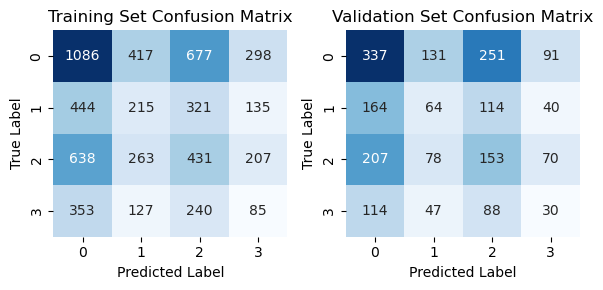

best_ICEA epochs=100 saved.


In [172]:
epochs_list = [50, 75, 100]
max_acc = 0
best_ICEA = None

for epochs in epochs_list:
    model_acc, model = epochs_adjustment(epochs)
    
    if model_acc > max_acc:
        max_acc = model_acc
        best_ICEA = model 
        print("best_ICEA epochs=" + str(epochs) + " saved.")
        
best_ICEA.save('output/ICEA.h5')
best_ICEA.save_weights('output/ICEA_weights.h5')

Although the model performed best when 100 epochs but there is overfitting as well as for all other epochs values. This mean 25 epochs is the suitable parameter.

### Altering Parameters

#### Regularization

In [173]:
def parmeter_tuning(hp):
    Lambda = hp.Float("lamda", min_value=1e-5, max_value=1e2, sampling="log")

    model_ICAP = tf.keras.Sequential([
        #VGG block 1
        tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        #VGG block 2
        tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Dropout(0.25),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(108, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(OUTPUT_CLASSES),
    ])
    
    lr= hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model_ICAP.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr),
                        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
                        metrics=['categorical_accuracy'])
    
    return model_ICAP

In [174]:
parmeter_tuning(keras_tuner.HyperParameters())

In [175]:
tuner = keras_tuner.RandomSearch(
    hypermodel=parmeter_tuning,
    objective="val_categorical_accuracy",
    max_trials=3,
    executions_per_trial=3,
    overwrite=True,
    directory="./patch_images/",
    project_name="Task2_ParameterTuning",
)

In [176]:
tuner.search_space_summary()

Search space summary
Default search space size: 2
lamda (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 100.0, 'step': None, 'sampling': 'log'}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}


In [177]:
tuner.search(train_generator, epochs=25, validation_data=validation_generator)

Trial 3 Complete [00h 03m 33s]
val_categorical_accuracy: 0.2477682282527288

Best val_categorical_accuracy So Far: 0.493178387482961
Total elapsed time: 00h 10m 36s
INFO:tensorflow:Oracle triggered exit


In [178]:
tuner.results_summary()

Results summary
Results in ./patch_images/Task2_ParameterTuning
Showing 10 best trials
Objective(name="val_categorical_accuracy", direction="max")

Trial 1 summary
Hyperparameters:
lamda: 1.0860565206609123e-05
lr: 0.0001222142432784057
Score: 0.493178387482961

Trial 2 summary
Hyperparameters:
lamda: 1.2597777585851058
lr: 0.0009256912616414935
Score: 0.2477682282527288

Trial 0 summary
Hyperparameters:
lamda: 3.663844969592256e-05
lr: 0.0015865794029742645
Score: 0.23041939735412598


- VGG2: 0.7550504803657532

The result shows original learning rate and lamdba performs the best

This shows that only earlystopping improves the model which will be applied to the Final model using VGG model with 2 blocks.

## Final Model

In [179]:
train_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.15,
                                   rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 5937 validated image filenames belonging to 4 classes.
Found 1979 validated image filenames belonging to 4 classes.
Found 1980 validated image filenames belonging to 4 classes.


In [180]:
model_CTFinal = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [181]:
model_CTFinal.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [182]:
history_CTFinal = model_CTFinal.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

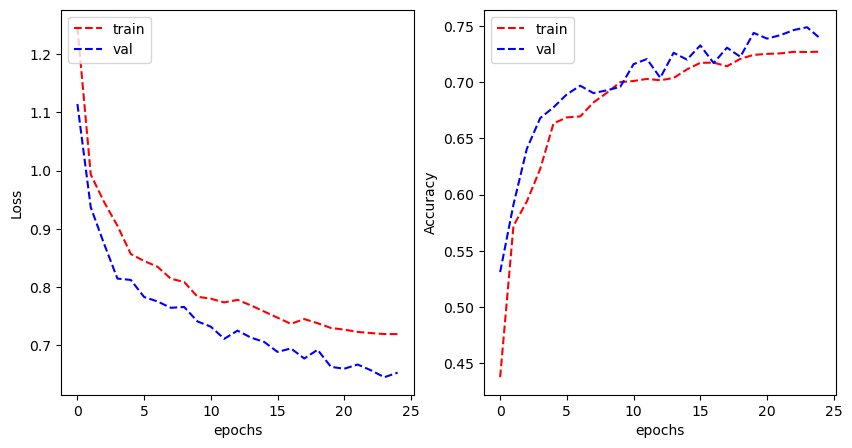

In [183]:
plot_learning_curve(history_CTFinal.history['loss'], history_CTFinal.history['val_loss'], 
                    history_CTFinal.history['categorical_accuracy'], history_CTFinal.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [184]:
model_CTFinal.evaluate(train_generator)
model_CTFinal.evaluate(validation_generator)
model_CTFinal.evaluate(test_generator)

62/62 [==============================] - 1s 15ms/step - loss: 0.6932 - categorical_accuracy: 0.7268


[0.693230926990509, 0.7267676591873169]

62/62 [==============================] - 1s 15ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.41      0.48      0.44      2478
           1       0.19      0.17      0.18      1115
           2       0.24      0.29      0.26      1539
           3       0.11      0.03      0.05       805

    accuracy                           0.31      5937
   macro avg       0.24      0.24      0.23      5937
weighted avg       0.29      0.31      0.29      5937

Validation set classification report:
               precision    recall  f1-score   support

           0       0.41      0.48      0.44       810
           1       0.18      0.16      0.17       382
           2       0.26      0.31      0.28       508
           3       0.10      0.03      0.04       279

    accuracy                           0.31      1979
   macro avg       0.24      0.24      0.23      1979
weighted avg       0.28      0.31      0.29      1979



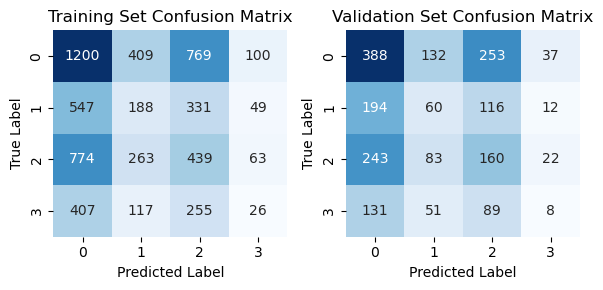

In [185]:
evaluation(train_generator, validation_generator, model_CTFinal)

In [186]:
#Code to store the model and weights 
model_CTFinal.save('output/CTFinal.h5')
model_CTFinal.save_weights('output/CTFinal_weights.h5')

## Predict cellTypeName from test set

In [187]:
test_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 1

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 1980 validated image filenames belonging to 4 classes.


In [188]:
label_names = {'fibroblast' : 0, 'inflammatory' : 1, 'epithelial' : 2, 'others' : 3}

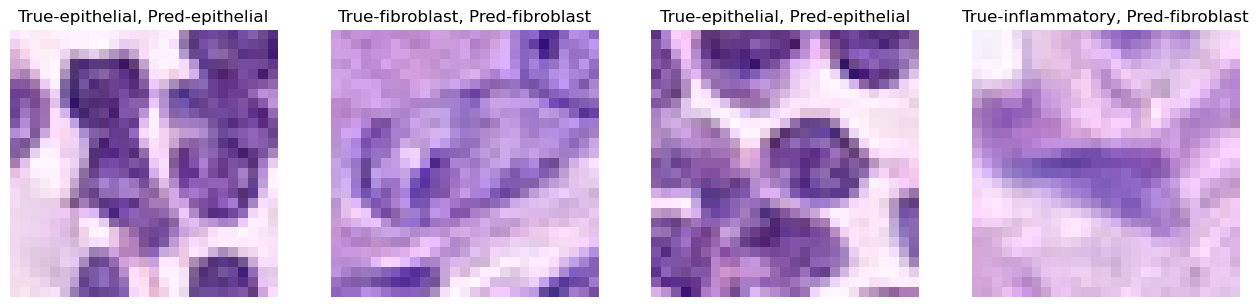

In [189]:
d_inv = {v: k for k, v in label_names.items()}
plt.figure(figsize=(20,4))
batches = 0
for x,y in test_generator:
        batches = batches + 1
        y_hat = model_CTFinal.predict(x, verbose=0)
        x = np.squeeze(x)
        if batches < 5:
            plt.subplot(1,5,batches)
            plt.imshow(x)
            plt.title("True-{}, Pred-{}".format(d_inv[np.argmax(y[0])], d_inv[np.argmax(y_hat[0])] ))
            
        else:
            break
        
        plt.axis('off')

## Extra + Main dataset

### Data Load

In [190]:
# new_df = extra + Main - Main['celltype']
extra_df = pd.read_csv("data_labels_extraData.csv", delimiter=',')

In [191]:
df_extra_data = extra_df.copy()

In [192]:
df_extra_data.head(5)

InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0

In [193]:
df_extra_data.shape

(10384, 4)

### Data Pre-Processing

In [194]:
extra_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 32

extra_generator = extra_datagen.flow_from_dataframe(
        dataframe=df_extra_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col=None,
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='input')

Found 10384 validated image filenames.


In [195]:
model_CTFinal.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 27, 27, 27)        756       
                                                                 
 conv2d_5 (Conv2D)           (None, 27, 27, 54)        13176     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 13, 13, 54)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 13, 13, 54)        0         
                                                                 
 conv2d_6 (Conv2D)           (None, 13, 13, 54)        26298     
                                                                 
 conv2d_7 (Conv2D)           (None, 13, 13, 108)       52596     
                                                      

CTFinal model with is VGG with 2 blocks with the base model parameter will be used to predict the extra dataset's cellTypeName

In [196]:
CTFinal_pred = model_CTFinal.predict(extra_generator)

325/325 [==============================] - 31s 95ms/step


In [197]:
cell_type_names = ['fibroblast', 'inflammatory', 'epithelial', 'others']

confidence_level = np.max(CTFinal_pred, axis=1)
max_indices = np.argmax(CTFinal_pred, axis=1)
cell_type_preds = [cell_type_names[i] for i in max_indices]

In [198]:
df_extra_data['cellTypeName'] = cell_type_preds
df_extra_data['cellType'] = max_indices
df_extra_data['confidenceLevel'] = confidence_level
df_extra_data.head(5)

InstanceID  patientID  ImageName  isCancerous cellTypeName  cellType  \
0       12681         61  12681.png            0   epithelial         2   
1       12682         61  12682.png            0   fibroblast         0   
2       12683         61  12683.png            0   epithelial         2   
3       12684         61  12684.png            0   fibroblast         0   
4       12685         61  12685.png            0   fibroblast         0   

   confidenceLevel  
0         0.752190  
1         3.856347  
2         2.168163  
3         3.018281  
4         4.006022

In [199]:
df_extra_data.describe()

InstanceID    patientID   isCancerous      cellType  confidenceLevel
count  10384.000000  10384.00000  10384.000000  10384.000000     10384.000000
mean   12087.866333     80.38203      0.287943      0.515986         3.373037
std     6173.866838      9.40388      0.452826      0.847823         2.002576
min     1631.000000     61.00000      0.000000      0.000000         0.344374
25%     6655.750000     71.00000      0.000000      0.000000         1.690572
50%    12377.500000     81.00000      0.000000      0.000000         2.813211
75%    16374.250000     88.00000      1.000000      1.000000         4.951974
max    22235.000000     99.00000      1.000000      3.000000         9.013549

In [200]:
threshold = df_extra_data['confidenceLevel'].quantile(q=0.5)
print(threshold)

2.8132107257843018


50th percentile is chosen as the threshhold which will remove half of the data that has low confidence level.
In this case, the threshold is 2.81

In [201]:
df_extra_data = df_extra_data[df_extra_data['confidenceLevel'] >= threshold]

In [202]:
print(str(len(CTFinal_pred) - df_extra_data.shape[0]) + " rows removed.")
print(df_extra_data.shape)
df_extra_data.head(5)

5192 rows removed.
(5192, 7)


InstanceID  patientID  ImageName  isCancerous cellTypeName  cellType  \
1       12682         61  12682.png            0   fibroblast         0   
3       12684         61  12684.png            0   fibroblast         0   
4       12685         61  12685.png            0   fibroblast         0   
7       12688         61  12688.png            0   fibroblast         0   
8       12689         61  12689.png            0   fibroblast         0   

   confidenceLevel  
1         3.856347  
3         3.018281  
4         4.006022  
7         6.660211  
8         7.496590

In [203]:
df_extra_data = df_extra_data.drop('confidenceLevel', axis=1)
df_extra_data.head(5)

InstanceID  patientID  ImageName  isCancerous cellTypeName  cellType
1       12682         61  12682.png            0   fibroblast         0
3       12684         61  12684.png            0   fibroblast         0
4       12685         61  12685.png            0   fibroblast         0
7       12688         61  12688.png            0   fibroblast         0
8       12689         61  12689.png            0   fibroblast         0

In [204]:
df_cancer_data = df_cancer_data.drop('ImgArray', axis=1)
df_cancer_data.head(5)

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

In [205]:
df_main_extra = pd.concat([df_cancer_data, df_extra_data], axis=0)
df_main_extra.reset_index(drop=True, inplace=True)

In [206]:
df_main_extra.shape

(15088, 6)

In [207]:
print(df_cancer_data.shape[0] + df_extra_data.shape[0])

15088


In [208]:
df_main_extra.head(5)

InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0

In [209]:
with pd.option_context('mode.chained_assignment', None):
    train_data, test_data = train_test_split(df_main_extra, test_size=0.2, random_state=42)
    train_data, val_data = train_test_split(train_data, test_size=0.25, random_state=42)

print("Train data : {}, Val Data: {}, Test Data: {}".format(train_data.shape[0], val_data.shape[0], test_data.shape[0]))

Train data : 9052, Val Data: 3018, Test Data: 3018


In [210]:
INPUT_DIM = (27,27,3)
HIDDEN_LAYER_DIM = 256
OUTPUT_CLASSES = 4

In [211]:
train_data['cellTypeName'] = train_data['cellTypeName'].astype('str')
val_data['cellTypeName'] = val_data['cellTypeName'].astype('str')
test_data['cellTypeName'] = test_data['cellTypeName'].astype('str')

### Final Model on main+extra dataset

In [212]:
train_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.15,
                                   rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
test_datagen = ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                 height_shift_range=0.2,shear_range=0.15,
                                 rescale=1./255, data_format='channels_last')
batch_size = 32

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=val_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

test_generator = test_datagen.flow_from_dataframe(
        dataframe=test_data,
        directory='./patch_images/',
        x_col="ImageName",
        y_col="cellTypeName",
        target_size=(27, 27),
        batch_size=batch_size,
        class_mode='categorical')

Found 9052 validated image filenames belonging to 4 classes.
Found 3018 validated image filenames belonging to 4 classes.
Found 3018 validated image filenames belonging to 4 classes.


In [213]:
model_CTFinal_extra = tf.keras.Sequential([
    #VGG block 1
    tf.keras.layers.Conv2D(27, (3, 3), activation='relu', padding='same', input_shape=INPUT_DIM),
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    #VGG block 2
    tf.keras.layers.Conv2D(54, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.Conv2D(108, (3, 3), activation='relu', padding='same'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Dropout(0.25),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(108, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(OUTPUT_CLASSES),
])

In [214]:
model_CTFinal_extra.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['categorical_accuracy'])

In [215]:
history_CTFinal_extra = model_CTFinal_extra.fit(train_generator, validation_data = validation_generator, epochs=25, verbose=0)

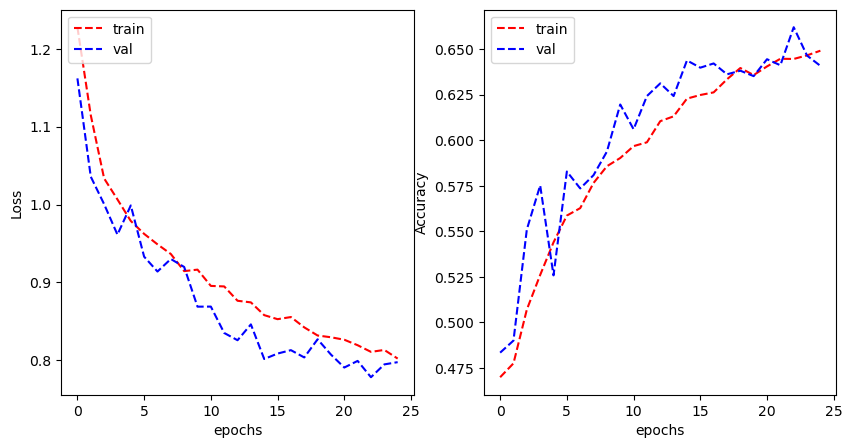

In [216]:
plot_learning_curve(history_CTFinal_extra.history['loss'], history_CTFinal_extra.history['val_loss'], 
                    history_CTFinal_extra.history['categorical_accuracy'], history_CTFinal_extra.history['val_categorical_accuracy'], 
                    metric_name='Accuracy')

In [217]:
model_CTFinal_extra.evaluate(train_generator)
model_CTFinal_extra.evaluate(validation_generator)
CTFinal_extra = model_CTFinal_extra.evaluate(test_generator)
CTFinal = model_CTFinal.evaluate(test_generator)
print("CTFinal: " + str(CTFinal[1]))
print("CTFinal_extra: " + str(CTFinal_extra[1]))

95/95 [==============================] - 2s 20ms/step - loss: 1.6307 - categorical_accuracy: 0.5133
CTFinal: 0.5132538080215454
CTFinal_extra: 0.6345261931419373


Using the original CTFinal model to predict combined main and extra dataset, it only shows 51.3% accuracy even though CTFinal model was used to predict the extra dataset's cellTypeName. On the other hands, CTFinal_extra which is exactly the same parameter as the CTFinal model but trained based on combined main and exta dataset, it shows outstanding result at 63.5% compared to CTFinal model which is increased by 12.1%p. 

95/95 [==============================] - 2s 21ms/step
Training set classification report:
               precision    recall  f1-score   support

           0       0.26      0.16      0.20      2447
           1       0.47      0.62      0.54      4259
           2       0.17      0.18      0.18      1528
           3       0.09      0.05      0.06       818

    accuracy                           0.37      9052
   macro avg       0.25      0.25      0.24      9052
weighted avg       0.33      0.37      0.34      9052

Validation set classification report:
               precision    recall  f1-score   support

           0       0.30      0.17      0.22       857
           1       0.45      0.62      0.53      1373
           2       0.18      0.18      0.18       524
           3       0.06      0.03      0.04       264

    accuracy                           0.37      3018
   macro avg       0.25      0.25      0.24      3018
weighted avg       0.33      0.37      0.34      3018



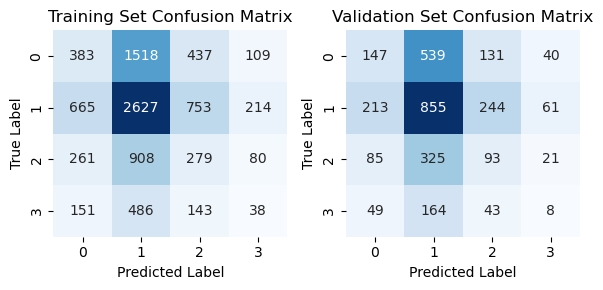

In [218]:
evaluation(train_generator, validation_generator, model_CTFinal_extra)

In [219]:
#Code to store the model and weights 
model_CTFinal_extra.save('output/CTFinal_extra.h5')
model_CTFinal_extra.save_weights('output/CTFinal_extra_weights.h5')